In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#Adapted from: 
# lqr_neural_error_dynamics.ipynb

import scipy.io as sio
import scipy.stats as sio_stat
import scipy.interpolate
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt 

import os
import pickle
import sys
import copy

import time
import pylab as pl
from IPython import display

from bmi_dynamics_code import behavior_co_obs as bmi_b
from bmi_dynamics_code import data_for_v as preeyacode
from bmi_dynamics_code import util as bmi_util

import timeit
from sklearn import decomposition as skl_decomp

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

%matplotlib notebook

In [3]:
%matplotlib notebook

In [4]:
# data_dir = '/Users/vivekathalye/Dropbox/Code/preeya_co_obstacle'
save_dir = r'D:\Dropbox\BMI_co_obs_paper\data\vivek\lqr'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
ext_list =['.png', '.eps']

home_dir = r'D:\Dropbox\Code\preeya_co_obstacle'
data_dir = r'D:\Dropbox\Data\preeya_co_obstacle'
data_path = os.path.join(data_dir, 'for_v_df.pkl')
print(os.path.exists(data_path))
d = pickle.load(open(data_path))

#UNPACK: 
decoder = d['decoder']
pre = d['pre']
num_targets = d['num_targets']
sample_period = d['sample_period']
target_hold_time = d['target_hold_time']
num_neurons = d['num_neurons']
target_color = d['target_color']
obs_big = d['obs_big']
obs_small = d['obs_small']
target_r_task = d['target_r_task'] #target_r_task = {0:1.7, 1:2.0}
cursor_r = d['cursor_r']
target_r_eff = d['target_r_eff']
target_pos = d['target_pos']
target_angle = np.arctan2(target_pos[:,1], target_pos[:,0])
target_dist = np.linalg.norm(target_pos, axis=1)
obs_pos = d['obs_pos']

tc_meta = d['tc_meta']
task_list = d['task_list']
num_tasks = len(task_list)
task2idx = d['task2idx']
idx2task = bmi_util.invert_dic(task2idx)
task2tc = d['task2tc']
tc_list = d['tc_list']
df = d['df']
df_label = d['df_label']

task_color = ['k', 'r']

#Pre-processing: 

bmi_b.preprocess_bmi_df(df, target_pos, pre, num_tasks, num_targets)
num_cw = 2
cw_label = ['cw', 'ccw']
task_rot_list = [0,1.1,1.2]

#Binning: 
#MAGNITUDE:
num_mag_bins = 5
num_mag_bins_analyze = 4
# mag_bin_perc = np.array([0,25,50,75,100])
mag_bin_perc = np.concatenate([np.linspace(0,95,5),np.array([100])])
#ANGLE:
num_angle_bins = 8
T0_angle = -3*(2*np.pi)/8
mag_bin, mag_bin_edges, mag_bin_c, angle_bin_c, angle_bin, angle_bin_edges =\
bmi_b.def_command_bin(df, mag_bin_perc, num_angle_bins, T0_angle)
#CENTER ANGLE DATA FOR BINNING (based on bin boundaries): 
angle_center_for_binning = bmi_b.df_center_angle_for_binning(df, angle_bin)
#BIN: 
bmi_b.df_bin_command(df, mag_bin_edges,angle_bin_edges)

#Pre-processing continued:

#Center angles to command bin, target: 
bmi_b.center_df_angle(df, angle_bin_c, target_angle)

True
('angle_center:', 22.5)
('min centered angle:', -157.47162455426732)
('max centered angle:', 202.46708261619673)


<IPython.core.display.Javascript object>


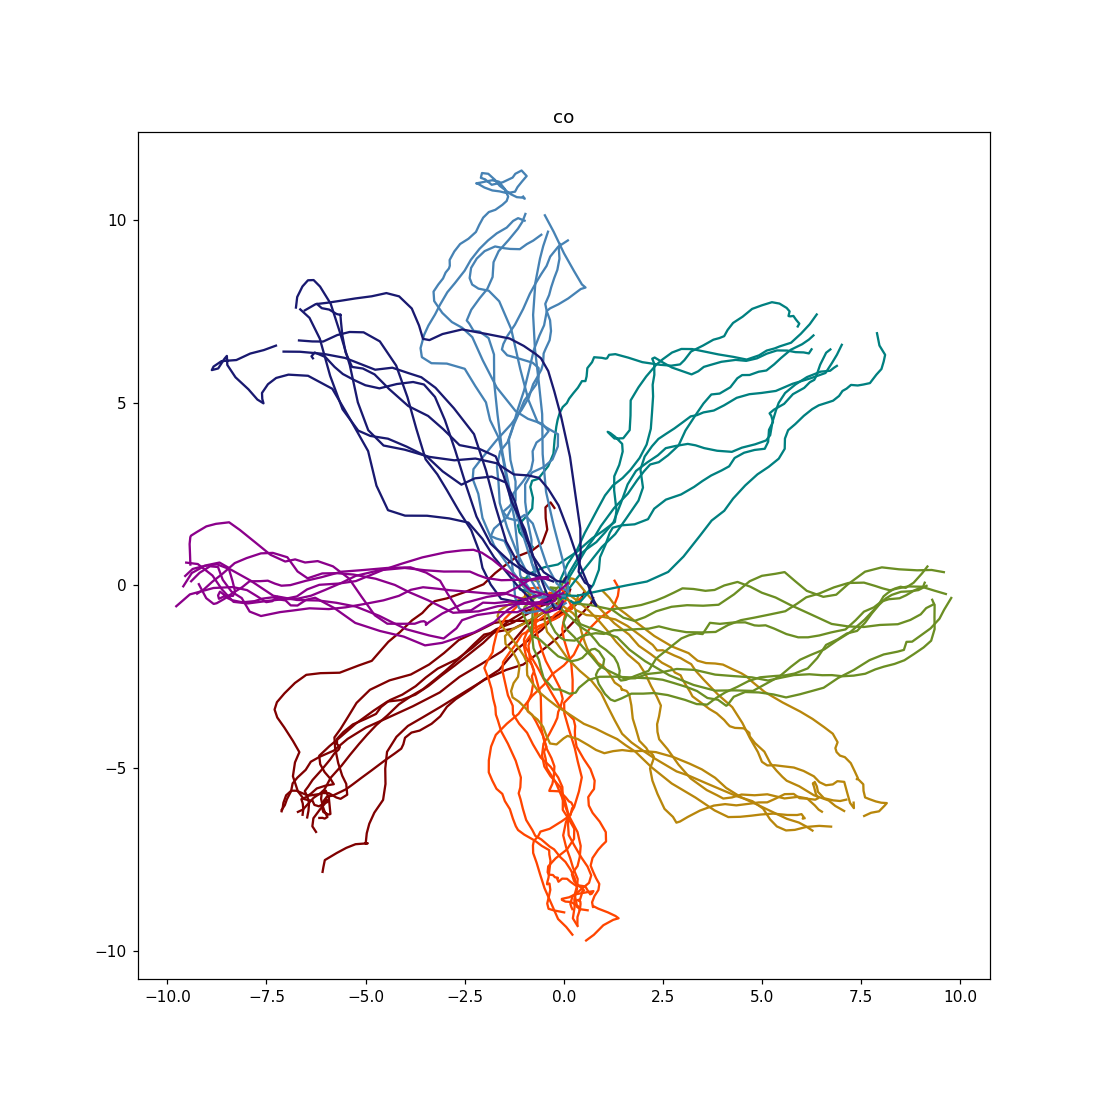

<IPython.core.display.Javascript object>


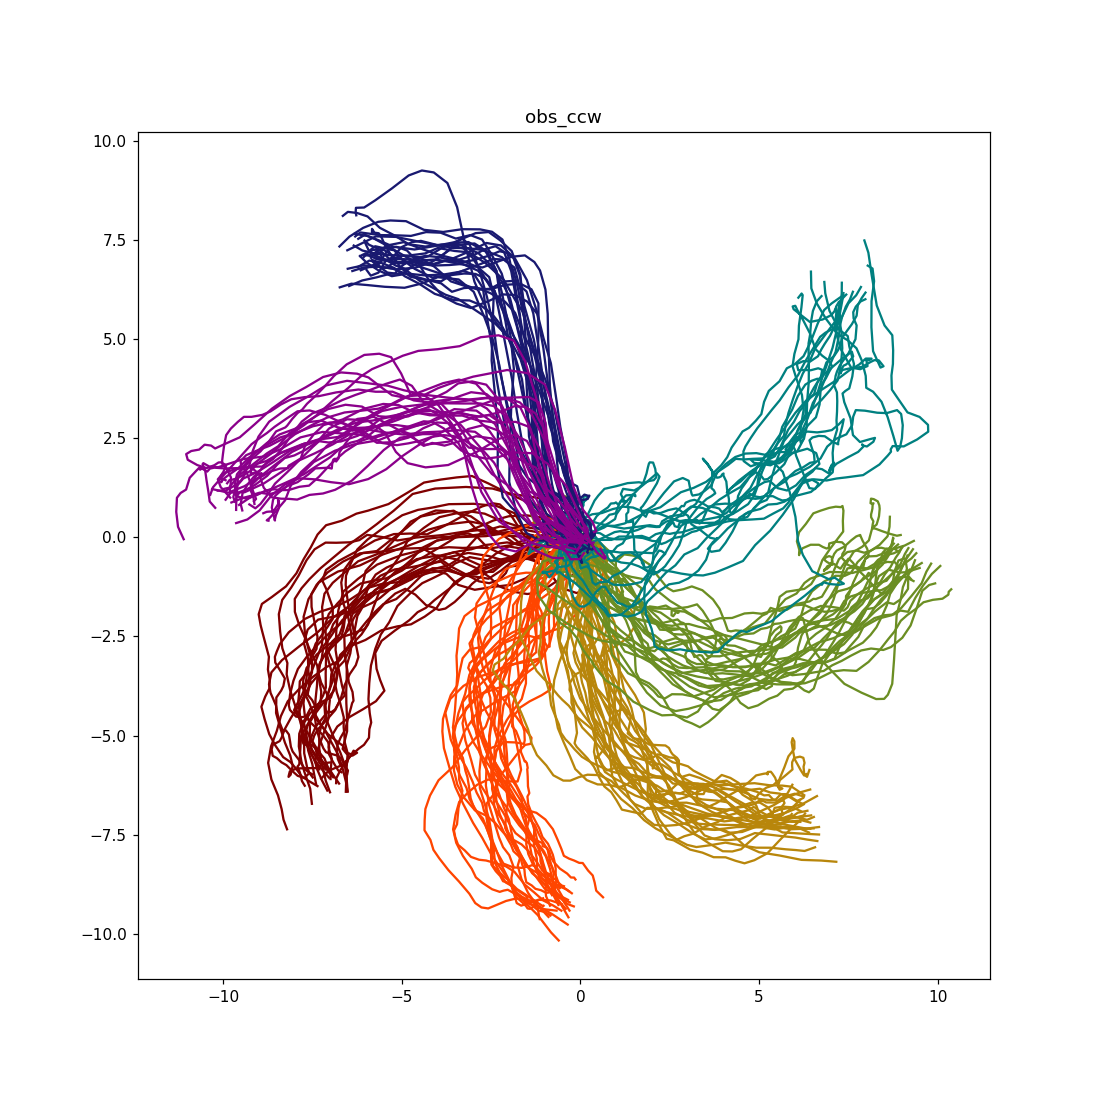

<IPython.core.display.Javascript object>


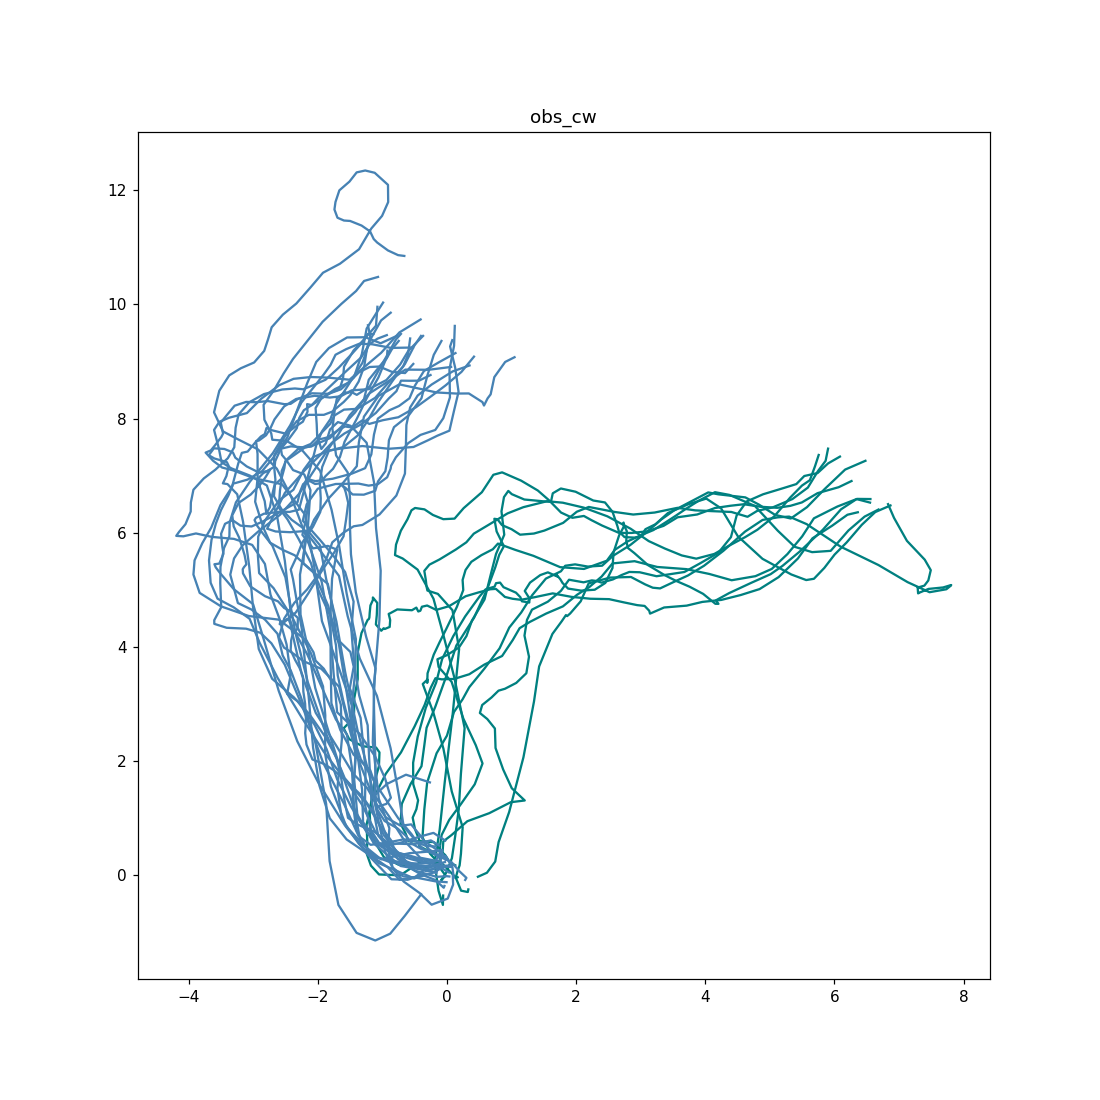

In [5]:
#Plot cw vs ccw trials, to confirm: 
plot = {}
plot['size'] = (10,10)
plot['xlim'] = (-12.5,12.5)
plot['ylim'] = (-12.5,12.5)
task_rot_list = [0,1.1,1.2]
task_rot_label = ['co','obs_ccw', 'obs_cw']

for i,task in enumerate(task_rot_list):
    plt.figure(figsize=plot['size'])
    plt.title(task_rot_label[i])
    for target in range(num_targets):    
            sel = (df['task_rot']==task) & (df['bin']>=0) & (df['target']==target)
            df_sel = df[sel]
            #------------------------------------------------------------------------------------
            #TRIALS: 
            trial_start = np.where(df_sel['bin']==0)[0]
            trial_stop = np.where(df_sel['bin_end']==0)[0]
            trial_bound = np.vstack((trial_start,trial_stop)).T
            #------------------------------------------------------------------------------------
            for bnd in trial_bound[:,:]: #trial_bound[0:1,:]:
    #             if (task_str == 'co') or (task_str == 'obs') and (df_sel['obs_size'][bnd[0]:bnd[0]+1] == obs_big).bool(): 
                x = df_sel['kin_px'][bnd[0]:bnd[1]+1]
                y = df_sel['kin_py'][bnd[0]:bnd[1]+1]
                color = target_color[target]
                plt.plot(x,y,'-',color=color)
                

4704     115.0
4755     116.0
4796     117.0
4842     118.0
4890     119.0
4941     120.0
4988     121.0
5046     122.0
5122     123.0
5392     127.0
10206    238.0
Name: trial_global, dtype: float64


<IPython.core.display.Javascript object>


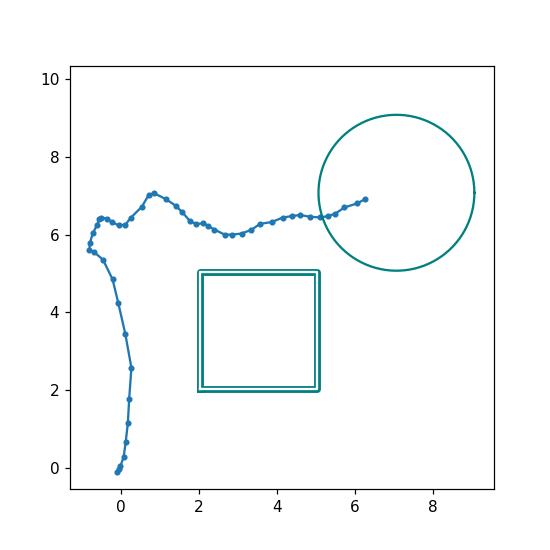

(-1.3012247717787875,
 9.564986506324725,
 -0.5427594616898825,
 10.32345181641363)

In [6]:
target = 4
sel_target = (df['target']==target)
sel_start = (df['bin']==0)
sel_task = (df['task_rot']==1.2) #1.2 is clockwise, 1.1 is counterclockwise
sel = sel_target&sel_start&sel_task
trials = df.loc[sel,'trial_global']
print(trials)

trial = int(trials.iloc[0])
sel_trial = (df['trial_global']==trial)
sel_bin = (df['bin']>=0)
sel = sel_trial&sel_bin

x = df.loc[sel, 'kin_px']
y = df.loc[sel, 'kin_py']

plt.figure(figsize=(5,5))
plt.plot(x,y, '.-')
c = target_color[target]
bmi_util.plot_obstacles(obs_pos[target,:].reshape((1,-1)), [c], obs_big*np.ones(1))
bmi_util.plot_targets(target_pos[target,:].reshape((1,-1)), [c], target_r_task[1]*np.ones(1))
plt.axis('square')

In [502]:
#LOAD:

load_decoder_null = True
a = 'grom'
d = str(0)

if load_decoder_null:
    save_path = os.path.join(r'D:\DATA\bmi_co_obs_backup', a, d, 'lqr_init_fp_decoder_null_noisy.pkl')
    #save_path = os.path.join(r'D:\DATA\bmi_co_obs_backup', a, d, 'lqr_init_zero_decoder_null.pkl')
    #save_path = os.path.join(r'D:\DATA\bmi_co_obs_backup', a, d, 'lqr_sim_Q2_decoder_null.pkl')
else:
    save_path = os.path.join(r'D:\DATA\bmi_co_obs_backup', a, d, 'lqr_init_fp_full_noisy.pkl')
    
    #save_path = os.path.join(r'D:\DATA\bmi_co_obs_backup', a, d, 'lqr_sim_Q2_full.pkl')

with open(save_path, 'rb') as f: 
    r = pickle.load(f)
#Note the simulations were run with neural activity initialized to 0    
for (k,v) in r.items():
    exec(k+'=v')

In [503]:
save_path

'D:\\DATA\\bmi_co_obs_backup\\grom\\0\\lqr_init_fp_decoder_null_noisy.pkl'

In [751]:
An_m.shape

(44L, 44L)

In [752]:
np.linalg.matrix_rank(An_m)

42

In [753]:
u,s,vh = np.linalg.svd(An_m)

In [763]:
s.shape

(44L,)

In [762]:
vh.shape

(44L, 44L)

In [787]:
s_mod = s
s_mod[-2:] = 0
print(s_mod)
An_m_test = np.dot(np.dot(u,np.diag(s_mod)), vh)

[2.46826941e-01 1.15322294e-01 9.18429529e-17 5.97318245e-17
 5.80777892e-17 5.74795835e-17 4.94574111e-17 4.32621651e-17
 3.79422464e-17 3.58281405e-17 2.32717497e-17 2.32717497e-17
 2.32717497e-17 2.32717497e-17 2.32717497e-17 2.32717497e-17
 2.32717497e-17 2.32717497e-17 2.32717497e-17 2.32717497e-17
 2.32717497e-17 2.32717497e-17 2.32717497e-17 2.32717497e-17
 2.32717497e-17 2.32717497e-17 2.32717497e-17 2.32717497e-17
 2.32717497e-17 2.32717497e-17 2.32717497e-17 2.32717497e-17
 2.32717497e-17 2.32717497e-17 2.32717497e-17 2.32717497e-17
 2.32717497e-17 2.32717497e-17 2.32717497e-17 1.89297536e-17
 1.81624883e-17 1.42736497e-17 0.00000000e+00 0.00000000e+00]


ValueError: shapes (44,44) and (49,49) not aligned: 44 (dim 1) != 49 (dim 0)

<IPython.core.display.Javascript object>


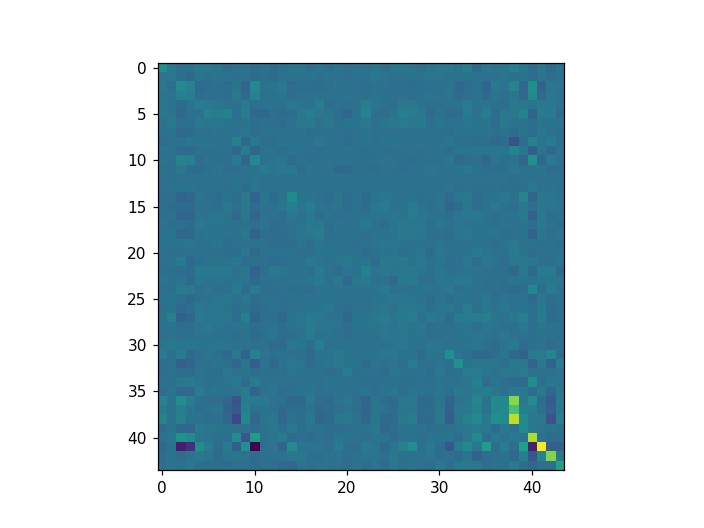

<IPython.core.display.Javascript object>


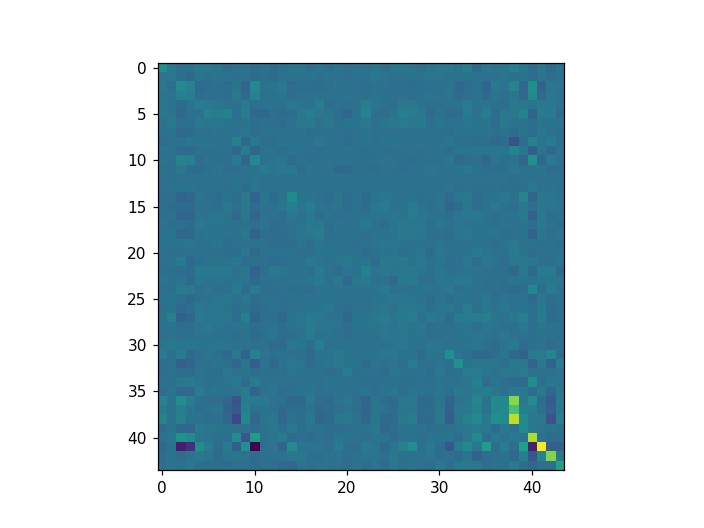

In [788]:
plt.figure()
plt.imshow(An_m)

plt.figure()
plt.imshow(An_m_test)

In [789]:
np.allclose(An_m_test, An_m)

True

In [791]:
np.max(An_m-An_m_test)

2.3939183968479938e-15

In [780]:
len(move_lqr_n[(3, 0, 'n_do')]['K_list']) #.shape #.keys()

1

In [784]:
move_lqr_n[(3, 0, 'n_do')]['K_list'][0][0,0].shape

(44L, 49L)

In [785]:
u,s,vh = np.linalg.svd(move_lqr_n[(3, 0, 'n_do')]['K_list'][0][0,0])

In [786]:
s

array([2.46826941e-01, 1.15322294e-01, 9.18429529e-17, 5.97318245e-17,
       5.80777892e-17, 5.74795835e-17, 4.94574111e-17, 4.32621651e-17,
       3.79422464e-17, 3.58281405e-17, 2.32717497e-17, 2.32717497e-17,
       2.32717497e-17, 2.32717497e-17, 2.32717497e-17, 2.32717497e-17,
       2.32717497e-17, 2.32717497e-17, 2.32717497e-17, 2.32717497e-17,
       2.32717497e-17, 2.32717497e-17, 2.32717497e-17, 2.32717497e-17,
       2.32717497e-17, 2.32717497e-17, 2.32717497e-17, 2.32717497e-17,
       2.32717497e-17, 2.32717497e-17, 2.32717497e-17, 2.32717497e-17,
       2.32717497e-17, 2.32717497e-17, 2.32717497e-17, 2.32717497e-17,
       2.32717497e-17, 2.32717497e-17, 2.32717497e-17, 1.89297536e-17,
       1.81624883e-17, 1.42736497e-17, 1.38095396e-17, 5.98102163e-18])

In [504]:
r.keys()

['state_dim',
 'num_neurons',
 'Qv_s',
 'norm_u_df_nl',
 'noise_dic',
 'num_offset',
 'A_dic',
 'num_trials',
 'input_label',
 'obs_margin',
 'Qfp_s',
 'Q_f',
 'state_label',
 'move_lqr_nl',
 'kin_var',
 'num_kin',
 'Qfv_s',
 'bn_m',
 'df_lqr_nl',
 'df_lqr_n',
 'B',
 'task_rot_list',
 'F',
 'n_init_dic',
 'R_s',
 'Kn',
 'Q',
 'target_list',
 'R',
 'offset_var',
 'waypoint_speed',
 'An_m',
 'A_list',
 'center',
 'model_list',
 'move_lqr_n',
 'norm_u_df_n',
 'Qp_s',
 'm_noise',
 'n_list',
 'move_horizon']

In [505]:
list(df_lqr_nl.columns)

['n_0',
 'n_1',
 'n_2',
 'n_3',
 'n_4',
 'n_5',
 'n_6',
 'n_7',
 'n_8',
 'n_9',
 'n_10',
 'n_11',
 'n_12',
 'n_13',
 'n_14',
 'n_15',
 'n_16',
 'n_17',
 'n_18',
 'n_19',
 'n_20',
 'n_21',
 'n_22',
 'n_23',
 'n_24',
 'n_25',
 'n_26',
 'n_27',
 'n_28',
 'n_29',
 'n_30',
 'n_31',
 'n_32',
 'n_33',
 'n_34',
 'n_35',
 'n_36',
 'n_37',
 'n_38',
 'n_39',
 'n_40',
 'n_41',
 'n_42',
 'n_43',
 'kin_px',
 'kin_py',
 'kin_vx',
 'kin_vy',
 'u_px',
 'u_py',
 'u_vx',
 'u_vy',
 'u_offset',
 'u_0',
 'u_1',
 'u_2',
 'u_3',
 'u_4',
 'u_5',
 'u_6',
 'u_7',
 'u_8',
 'u_9',
 'u_10',
 'u_11',
 'u_12',
 'u_13',
 'u_14',
 'u_15',
 'u_16',
 'u_17',
 'u_18',
 'u_19',
 'u_20',
 'u_21',
 'u_22',
 'u_23',
 'u_24',
 'u_25',
 'u_26',
 'u_27',
 'u_28',
 'u_29',
 'u_30',
 'u_31',
 'u_32',
 'u_33',
 'u_34',
 'u_35',
 'u_36',
 'u_37',
 'u_38',
 'u_39',
 'u_40',
 'u_41',
 'u_42',
 'u_43',
 'task_rot',
 'target',
 'bin',
 'bin_end',
 'trial',
 'model',
 'p_mag',
 'p_angle',
 'v_mag',
 'v_angle',
 'u_p_mag',
 'u_p_angle',
 

In [506]:
list(df_lqr_n.columns)

['n_0',
 'n_1',
 'n_2',
 'n_3',
 'n_4',
 'n_5',
 'n_6',
 'n_7',
 'n_8',
 'n_9',
 'n_10',
 'n_11',
 'n_12',
 'n_13',
 'n_14',
 'n_15',
 'n_16',
 'n_17',
 'n_18',
 'n_19',
 'n_20',
 'n_21',
 'n_22',
 'n_23',
 'n_24',
 'n_25',
 'n_26',
 'n_27',
 'n_28',
 'n_29',
 'n_30',
 'n_31',
 'n_32',
 'n_33',
 'n_34',
 'n_35',
 'n_36',
 'n_37',
 'n_38',
 'n_39',
 'n_40',
 'n_41',
 'n_42',
 'n_43',
 'kin_px',
 'kin_py',
 'kin_vx',
 'kin_vy',
 'u_px',
 'u_py',
 'u_vx',
 'u_vy',
 'u_offset',
 'u_0',
 'u_1',
 'u_2',
 'u_3',
 'u_4',
 'u_5',
 'u_6',
 'u_7',
 'u_8',
 'u_9',
 'u_10',
 'u_11',
 'u_12',
 'u_13',
 'u_14',
 'u_15',
 'u_16',
 'u_17',
 'u_18',
 'u_19',
 'u_20',
 'u_21',
 'u_22',
 'u_23',
 'u_24',
 'u_25',
 'u_26',
 'u_27',
 'u_28',
 'u_29',
 'u_30',
 'u_31',
 'u_32',
 'u_33',
 'u_34',
 'u_35',
 'u_36',
 'u_37',
 'u_38',
 'u_39',
 'u_40',
 'u_41',
 'u_42',
 'u_43',
 'task_rot',
 'target',
 'bin',
 'bin_end',
 'trial',
 'model',
 'p_mag',
 'p_angle',
 'v_mag',
 'v_angle',
 'u_p_mag',
 'u_p_angle',
 

#### Decoder space projections

In [507]:
Kn.shape

(5L, 44L)

In [508]:
#Decoder projections
decoder_rank = 2
mat = Kn.T #num_cursor_var X num_neurons #decoder_dic[a,d,'KG'].T
u,s,vh = np.linalg.svd(mat)
decoder_space = np.mat(u[:,:decoder_rank])
decoder_proj = decoder_space*decoder_space.T#np.matmul(decoder_space, decoder_space.T)

decoder_null_space = u[:,decoder_rank:]
decoder_null_proj = np.eye(decoder_proj.shape[0])-decoder_proj

#### Choose df

In [696]:
load_type = 'noisy'
# load_type = 'noiseless'

if load_type == 'noiseless':
    df_lqr = df_lqr_nl
    move_lqr = move_lqr_nl
elif load_type == 'noisy':
    df_lqr = df_lqr_n
    move_lqr = move_lqr_n

#### Confirm binning of commands

<IPython.core.display.Javascript object>


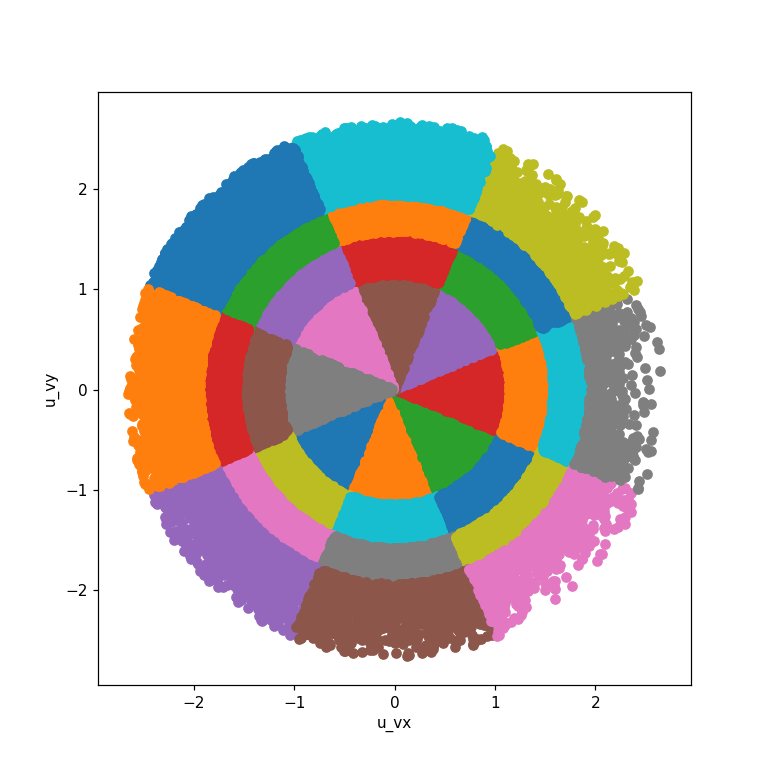

Text(0,0.5,'u_vy')

In [511]:
#Plot commands in a bin: 
num_mag_bins_analyze = 4
num_angle_bins = 8

plt.figure(figsize=(7,7))
for mag_bin in range(num_mag_bins_analyze):
    for angle_bin in range(num_angle_bins):
        sel_mag = df_lqr['u_v_mag_bin']==mag_bin
        sel_angle = df_lqr['u_v_angle_bin']==angle_bin
        sel = sel_mag&sel_angle
        d_c = df_lqr[sel][['u_vx', 'u_vy']]

        plt.scatter(d_c['u_vx'], d_c['u_vy'])
plt.axis('square')
plt.xlabel('u_vx')
plt.ylabel('u_vy')

In [512]:
df_lqr.head()

,n_0,n_1,n_2,n_3,n_4,n_5,n_6,n_7,n_8,n_9,...,u_p_angle,u_v_mag,u_v_angle,u_v_mag_bin,u_v_angle_bin,p_angle_ctr_t,v_angle_ctr_t,u_p_angle_ctr_t,u_v_angle_ctr_t,u_v_angle_ctr_bin
0,1.328601,0.496140,0.004279,-0.003336,1.202276,2.318799,1.388266,0.256369,-0.072159,0.081946,...,1.638770,8.561128e-15,1.655690,0.0,5.0,0.000000,0.000000,-4.644415,-4.627495,1.655690
1,1.649806,0.829527,0.752275,0.188004,1.613684,2.270020,1.021909,0.219886,-0.403178,0.372023,...,-2.374501,1.149972e+00,-2.374501,1.0,0.0,-0.581557,-0.581557,-2.374501,-2.374501,-2.374501
2,1.124026,0.880530,0.892030,0.243215,1.187094,2.570464,1.294524,0.152712,-0.812758,0.359845,...,-2.025126,1.425180e+00,-2.025126,1.0,0.0,-1.876363,-2.095460,-2.025126,-2.025126,-2.025126
3,1.439230,-0.268959,0.558292,-0.130732,1.176517,2.831184,1.347834,0.151351,-0.124002,0.587082,...,-2.582004,1.301340e+00,-2.582004,1.0,0.0,-1.928857,-1.940694,-2.582004,-2.582004,-2.582004
4,1.180915,0.203647,-0.171161,0.509937,1.467431,2.638515,1.602753,0.389464,-0.490388,0.385824,...,-2.519214,7.689903e-01,-2.519214,0.0,0.0,-2.030434,-2.206870,-2.519214,-2.519214,-2.519214


In [513]:
r.keys()

['state_dim',
 'num_neurons',
 'Qv_s',
 'norm_u_df_nl',
 'noise_dic',
 'num_offset',
 'A_dic',
 'num_trials',
 'input_label',
 'obs_margin',
 'Qfp_s',
 'Q_f',
 'state_label',
 'move_lqr_nl',
 'kin_var',
 'num_kin',
 'Qfv_s',
 'bn_m',
 'df_lqr_nl',
 'df_lqr_n',
 'B',
 'task_rot_list',
 'F',
 'n_init_dic',
 'R_s',
 'Kn',
 'Q',
 'target_list',
 'R',
 'offset_var',
 'waypoint_speed',
 'An_m',
 'A_list',
 'center',
 'model_list',
 'move_lqr_n',
 'norm_u_df_n',
 'Qp_s',
 'm_noise',
 'n_list',
 'move_horizon']

In [514]:
list(df_lqr.columns)

['n_0',
 'n_1',
 'n_2',
 'n_3',
 'n_4',
 'n_5',
 'n_6',
 'n_7',
 'n_8',
 'n_9',
 'n_10',
 'n_11',
 'n_12',
 'n_13',
 'n_14',
 'n_15',
 'n_16',
 'n_17',
 'n_18',
 'n_19',
 'n_20',
 'n_21',
 'n_22',
 'n_23',
 'n_24',
 'n_25',
 'n_26',
 'n_27',
 'n_28',
 'n_29',
 'n_30',
 'n_31',
 'n_32',
 'n_33',
 'n_34',
 'n_35',
 'n_36',
 'n_37',
 'n_38',
 'n_39',
 'n_40',
 'n_41',
 'n_42',
 'n_43',
 'kin_px',
 'kin_py',
 'kin_vx',
 'kin_vy',
 'u_px',
 'u_py',
 'u_vx',
 'u_vy',
 'u_offset',
 'u_0',
 'u_1',
 'u_2',
 'u_3',
 'u_4',
 'u_5',
 'u_6',
 'u_7',
 'u_8',
 'u_9',
 'u_10',
 'u_11',
 'u_12',
 'u_13',
 'u_14',
 'u_15',
 'u_16',
 'u_17',
 'u_18',
 'u_19',
 'u_20',
 'u_21',
 'u_22',
 'u_23',
 'u_24',
 'u_25',
 'u_26',
 'u_27',
 'u_28',
 'u_29',
 'u_30',
 'u_31',
 'u_32',
 'u_33',
 'u_34',
 'u_35',
 'u_36',
 'u_37',
 'u_38',
 'u_39',
 'u_40',
 'u_41',
 'u_42',
 'u_43',
 'task_rot',
 'target',
 'bin',
 'bin_end',
 'trial',
 'model',
 'p_mag',
 'p_angle',
 'v_mag',
 'v_angle',
 'u_p_mag',
 'u_p_angle',
 

In [515]:
df_lqr[n_list+u_list+['model']].head()

,n_0,n_1,n_2,n_3,n_4,n_5,n_6,n_7,n_8,n_9,...,n_40,n_41,n_42,n_43,u_px,u_py,u_vx,u_vy,u_offset,model
0,1.328601,0.496140,0.004279,-0.003336,1.202276,2.318799,1.388266,0.256369,-0.072159,0.081946,...,1.846951,2.698120,0.732795,1.236763,-5.788468e-17,8.502597e-16,-7.259137e-16,8.530297e-15,0.0,n_do
1,1.649806,0.829527,0.752275,0.188004,1.613684,2.270020,1.021909,0.219886,-0.403178,0.372023,...,1.541427,2.902220,0.474658,1.129679,-8.279014e-02,-7.981315e-02,-8.279014e-01,-7.981315e-01,0.0,n_do
2,1.124026,0.880530,0.892030,0.243215,1.187094,2.570464,1.294524,0.152712,-0.812758,0.359845,...,1.443687,3.708332,0.536765,1.389716,-6.254543e-02,-1.280603e-01,-6.254543e-01,-1.280603e+00,0.0,n_do
3,1.439230,-0.268959,0.558292,-0.130732,1.176517,2.831184,1.347834,0.151351,-0.124002,0.587082,...,1.261733,3.576305,0.789064,1.345286,-1.102852e-01,-6.908003e-02,-1.102852e+00,-6.908003e-01,0.0,n_do
4,1.180915,0.203647,-0.171161,0.509937,1.467431,2.638515,1.602753,0.389464,-0.490388,0.385824,...,1.318869,3.064386,0.700153,1.079366,-6.248000e-02,-4.482978e-02,-6.248000e-01,-4.482978e-01,0.0,n_do


#### Reconstruct command

In [516]:
#Reconstruct command: 
Kn_mat = np.mat(Kn)

#Choose a time sample
i = 1700
n_df = df_lqr.iloc[i][n_list]
n_mat = np.mat(n_df).T

u_list = ['u_px','u_py','u_vx','u_vy','u_offset']
u_df = df_lqr.iloc[i][u_list]
u_mat = np.mat(u_df).T
print('saved command')
print(u_mat) 

#Reconstruct command 'u_mat'
u_mat_recon = Kn_mat*n_mat
u_mat_recon.shape
print('recon command')
print(u_mat_recon)

saved command
[[-0.07913244816453065]
 [-0.03845356916586007]
 [-0.7913244816453108]
 [-0.38453569165860296]
 [0.0]]
recon command
[[-0.07913244816453067]
 [-0.038453569165860076]
 [-0.7913244816453108]
 [-0.3845356916586029]
 [0.0]]


#### Confirm noise level

In [517]:
list(df_lqr.columns)

['n_0',
 'n_1',
 'n_2',
 'n_3',
 'n_4',
 'n_5',
 'n_6',
 'n_7',
 'n_8',
 'n_9',
 'n_10',
 'n_11',
 'n_12',
 'n_13',
 'n_14',
 'n_15',
 'n_16',
 'n_17',
 'n_18',
 'n_19',
 'n_20',
 'n_21',
 'n_22',
 'n_23',
 'n_24',
 'n_25',
 'n_26',
 'n_27',
 'n_28',
 'n_29',
 'n_30',
 'n_31',
 'n_32',
 'n_33',
 'n_34',
 'n_35',
 'n_36',
 'n_37',
 'n_38',
 'n_39',
 'n_40',
 'n_41',
 'n_42',
 'n_43',
 'kin_px',
 'kin_py',
 'kin_vx',
 'kin_vy',
 'u_px',
 'u_py',
 'u_vx',
 'u_vy',
 'u_offset',
 'u_0',
 'u_1',
 'u_2',
 'u_3',
 'u_4',
 'u_5',
 'u_6',
 'u_7',
 'u_8',
 'u_9',
 'u_10',
 'u_11',
 'u_12',
 'u_13',
 'u_14',
 'u_15',
 'u_16',
 'u_17',
 'u_18',
 'u_19',
 'u_20',
 'u_21',
 'u_22',
 'u_23',
 'u_24',
 'u_25',
 'u_26',
 'u_27',
 'u_28',
 'u_29',
 'u_30',
 'u_31',
 'u_32',
 'u_33',
 'u_34',
 'u_35',
 'u_36',
 'u_37',
 'u_38',
 'u_39',
 'u_40',
 'u_41',
 'u_42',
 'u_43',
 'task_rot',
 'target',
 'bin',
 'bin_end',
 'trial',
 'model',
 'p_mag',
 'p_angle',
 'v_mag',
 'v_angle',
 'u_p_mag',
 'u_p_angle',
 

In [518]:
r.keys()

['state_dim',
 'num_neurons',
 'Qv_s',
 'norm_u_df_nl',
 'noise_dic',
 'num_offset',
 'A_dic',
 'num_trials',
 'input_label',
 'obs_margin',
 'Qfp_s',
 'Q_f',
 'state_label',
 'move_lqr_nl',
 'kin_var',
 'num_kin',
 'Qfv_s',
 'bn_m',
 'df_lqr_nl',
 'df_lqr_n',
 'B',
 'task_rot_list',
 'F',
 'n_init_dic',
 'R_s',
 'Kn',
 'Q',
 'target_list',
 'R',
 'offset_var',
 'waypoint_speed',
 'An_m',
 'A_list',
 'center',
 'model_list',
 'move_lqr_n',
 'norm_u_df_n',
 'Qp_s',
 'm_noise',
 'n_list',
 'move_horizon']

In [667]:
r['move_lqr_n'].keys()

[(4, 1.1, 'n_d'),
 (3, 0, 'n_null'),
 (3, 1.2, 'n_do'),
 (0, 1.1, 'n_null'),
 (5, 1.2, 'n_d'),
 (4, 1.2, 'n_null'),
 (2, 1.2, 'n_null'),
 (1, 1.2, 'n_null'),
 (0, 1.2, 'n_d'),
 (6, 0, 'n_o'),
 (3, 1.2, 'n_o'),
 (2, 0, 'n_null'),
 (3, 0, 'n_d'),
 (6, 1.2, 'n_null'),
 (5, 1.2, 'n_null'),
 (4, 1.2, 'n_d'),
 (7, 0, 'n_do'),
 (0, 0, 'n_do'),
 (2, 1.2, 'n_d'),
 (1, 0, 'n_do'),
 (1, 1.2, 'n_d'),
 (3, 1.1, 'n_do'),
 (7, 1.2, 'n_o'),
 (1, 1.1, 'n_do'),
 (7, 1.1, 'n_o'),
 (5, 0, 'n_null'),
 (1, 0, 'n_o'),
 (5, 1.1, 'n_o'),
 (6, 1.2, 'n_d'),
 (7, 1.1, 'n_do'),
 (5, 1.1, 'n_do'),
 (6, 1.1, 'n_d'),
 (4, 0, 'n_o'),
 (2, 1.1, 'n_null'),
 (5, 0, 'n_d'),
 (7, 1.2, 'n_do'),
 (1, 1.1, 'n_o'),
 (0, 0, 'n_null'),
 (3, 1.1, 'n_null'),
 (6, 1.1, 'n_null'),
 (4, 1.1, 'n_o'),
 (0, 1.2, 'n_o'),
 (2, 1.1, 'n_d'),
 (3, 1.2, 'n_d'),
 (2, 0, 'n_do'),
 (1, 1.2, 'n_do'),
 (3, 0, 'n_do'),
 (6, 0, 'n_d'),
 (7, 0, 'n_o'),
 (0, 1.2, 'n_do'),
 (0, 0, 'n_d'),
 (4, 1.2, 'n_o'),
 (0, 1.1, 'n_do'),
 (3, 1.1, 'n_d'),
 (0, 1.1,

In [519]:
A_list

['n_do', 'n_o', 'n_null', 'n_d', 'n_decoder_null']

In [520]:
A_dic.keys()

['n_null', 'n_d', 'n_do', 'n_o']

In [521]:
Kn.shape

(5L, 44L)

In [522]:
move_lqr[(3, 1.2, 'n_do')].keys()

['A',
 'Q_f',
 'sim_len',
 'B',
 'K_list',
 'move_len',
 'state_noise_list',
 'state_e_list',
 'Q',
 'R',
 'u_list',
 'state_init',
 'horizon_list',
 'state_list',
 'A_e_list',
 'state_T_list']

('condition', 0, 0)


<IPython.core.display.Javascript object>


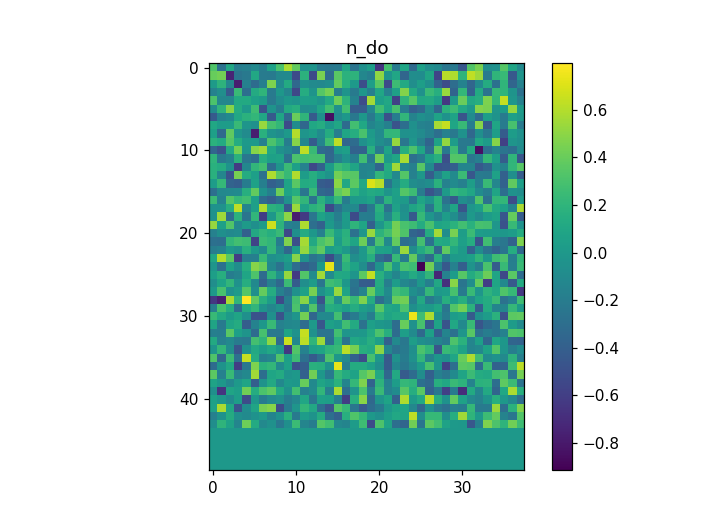

<IPython.core.display.Javascript object>


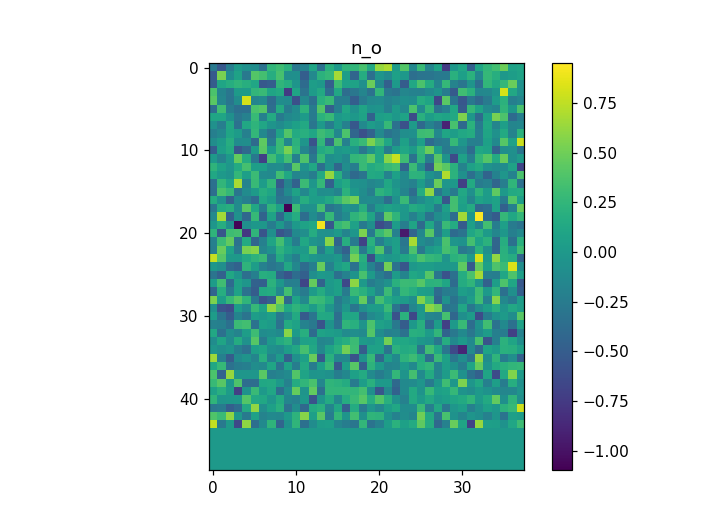

Text(0.5,1,'n_o')

In [523]:
#Inspect the noise level
#NOTE: the state_noise_list had a bug in saving, i only have one trial of the noise.
target = 0
task_rot = 0

print('condition', target, task_rot)

m = 'n_do'
noise_ex = move_lqr[(target, task_rot, m)]['state_noise_list'][0]
plt.figure()
plt.imshow(noise_ex)
plt.colorbar()
plt.title(m)

m = 'n_o'
noise_ex = move_lqr[(target, task_rot, m)]['state_noise_list'][0]
plt.figure()
plt.imshow(noise_ex)
plt.colorbar()
plt.title(m)


#### check how much decoder-null, decoder-potent variance there is

In [524]:
print('decoder null variance')
for m in ['n_do', 'n_o']:
    sel_m = df_lqr['model']==m
    n_mat = np.mat(df_lqr[sel_m][n_list]).T
    n_null = decoder_null_proj*n_mat
    null_var = np.trace(np.cov(n_null))
    print(m, null_var)

decoder null variance
('n_do', 3.477119525028043)
('n_o', 3.0827278572829635)


In [525]:
print('decoder potent variance')
for m in ['n_do', 'n_o']:
    sel_m = df_lqr['model']==m
    n_mat = np.mat(df_lqr[sel_m][n_list]).T
    n_potent = decoder_proj*n_mat
    potent_var = np.trace(np.cov(n_potent))
    print(m, potent_var)

decoder potent variance
('n_do', 3.486634201275487)
('n_o', 3.4818033801694326)


#### check inputs to neurons do not enter decoder-null space

In [526]:
num_neurons

44L

In [527]:
input_list = ['u_'+str(i) for i in range(num_neurons)]
input_list

['u_0',
 'u_1',
 'u_2',
 'u_3',
 'u_4',
 'u_5',
 'u_6',
 'u_7',
 'u_8',
 'u_9',
 'u_10',
 'u_11',
 'u_12',
 'u_13',
 'u_14',
 'u_15',
 'u_16',
 'u_17',
 'u_18',
 'u_19',
 'u_20',
 'u_21',
 'u_22',
 'u_23',
 'u_24',
 'u_25',
 'u_26',
 'u_27',
 'u_28',
 'u_29',
 'u_30',
 'u_31',
 'u_32',
 'u_33',
 'u_34',
 'u_35',
 'u_36',
 'u_37',
 'u_38',
 'u_39',
 'u_40',
 'u_41',
 'u_42',
 'u_43']

In [528]:
print('decoder null variance of inputs')
for m in ['n_do', 'n_o']:
    sel_m = df_lqr['model']==m
    u_mat = np.mat(df_lqr[sel_m][input_list]).T
    u_null = decoder_null_proj*u_mat
    null_var = np.trace(np.cov(u_null))
    print(m, null_var)

decoder null variance of inputs
('n_do', 6.048901991239253e-28)
('n_o', 5.031715415201691e-28)


In [529]:
print('decoder potent variance of inputs')
for m in ['n_do', 'n_o']:
    sel_m = df_lqr['model']==m
    u_mat = np.mat(df_lqr[sel_m][input_list]).T
    u_potent = decoder_proj*u_mat
    potent_var = np.trace(np.cov(u_potent))
    print(m, potent_var)

decoder potent variance of inputs
('n_do', 3.3398681800034606)
('n_o', 3.3407410752782347)


#### compare two conditions for the same command

In [361]:
#TODO:

#### poor man's matching

In [530]:
list(df_lqr.columns)

['n_0',
 'n_1',
 'n_2',
 'n_3',
 'n_4',
 'n_5',
 'n_6',
 'n_7',
 'n_8',
 'n_9',
 'n_10',
 'n_11',
 'n_12',
 'n_13',
 'n_14',
 'n_15',
 'n_16',
 'n_17',
 'n_18',
 'n_19',
 'n_20',
 'n_21',
 'n_22',
 'n_23',
 'n_24',
 'n_25',
 'n_26',
 'n_27',
 'n_28',
 'n_29',
 'n_30',
 'n_31',
 'n_32',
 'n_33',
 'n_34',
 'n_35',
 'n_36',
 'n_37',
 'n_38',
 'n_39',
 'n_40',
 'n_41',
 'n_42',
 'n_43',
 'kin_px',
 'kin_py',
 'kin_vx',
 'kin_vy',
 'u_px',
 'u_py',
 'u_vx',
 'u_vy',
 'u_offset',
 'u_0',
 'u_1',
 'u_2',
 'u_3',
 'u_4',
 'u_5',
 'u_6',
 'u_7',
 'u_8',
 'u_9',
 'u_10',
 'u_11',
 'u_12',
 'u_13',
 'u_14',
 'u_15',
 'u_16',
 'u_17',
 'u_18',
 'u_19',
 'u_20',
 'u_21',
 'u_22',
 'u_23',
 'u_24',
 'u_25',
 'u_26',
 'u_27',
 'u_28',
 'u_29',
 'u_30',
 'u_31',
 'u_32',
 'u_33',
 'u_34',
 'u_35',
 'u_36',
 'u_37',
 'u_38',
 'u_39',
 'u_40',
 'u_41',
 'u_42',
 'u_43',
 'task_rot',
 'target',
 'bin',
 'bin_end',
 'trial',
 'model',
 'p_mag',
 'p_angle',
 'v_mag',
 'v_angle',
 'u_p_mag',
 'u_p_angle',
 

In [531]:
task_rot_list

[0, 1.1, 1.2]

('n_do', array([ 3123,  3125,  3126,  3132,  3133,  3135,  3163,  3165,  3166,
        3167,  3172,  3174,  3199,  3200,  3203,  3212,  3213,  3239,
        3243,  3244,  3247,  3248,  3250,  3251,  3252,  3278,  3286,
        3289,  3291,  3292,  3316,  3317,  3320,  3321,  3323,  3327,
        3330,  3331,  3360,  3361,  3368,  3369,  3397,  3399,  3401,
        3404,  3407,  3439,  3440,  3441,  3445,  3446,  3447,  3476,
        3477,  3481,  3482,  3483,  3485,  3486,  3487,  3511,  3514,
        3518,  3522,  3523,  3524,  3525,  3526,  3550,  3552,  3557,
        3558,  3561,  3564,  3565,  3590,  3593,  3594,  3595,  3599,
        3601,  3602,  3603,  3604,  3629,  3634,  3638,  3640,  3641,
        3642,  3668,  3671,  3675,  3678,  3679,  3681,  3706,  3707,
        3709,  3710,  3711,  3715,  3717,  3745,  3749,  3751,  3755,
        3758,  3759,  3760,  3784,  3788,  3794,  3795,  3823,  3824,
        3826,  3831,  3832,  3834,  3838,  3863,  3865,  3866,  3867,
        387

<IPython.core.display.Javascript object>


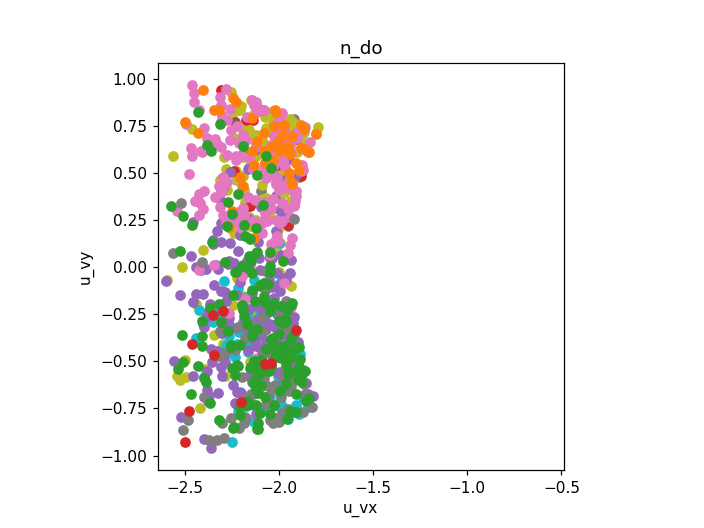

('n_do', 'c', array([], dtype=int64))
('n_do', 'c', array([], dtype=int64))
('n_do', 'c', array([], dtype=int64))
('n_do', 'c', array([], dtype=int64))
('n_do', 'c', array([], dtype=int64))
('n_do', 'c', array([], dtype=int64))
('n_do', 'c', array([], dtype=int64))
('n_do', 'c', array([65570, 65591, 65630, 65650, 65670, 65684, 65689, 65709, 65786,
       65834, 65862, 65875, 65898, 65956, 65995, 66053, 66076, 66088,
       66136, 66171, 66242, 66294], dtype=int64))
('n_do', 'c', array([3123, 3125, 3126, 3132, 3133, 3135, 3163, 3165, 3166, 3167, 3172,
       3174, 3199, 3200, 3203, 3212, 3213, 3239, 3243, 3244, 3247, 3248,
       3250, 3251, 3252, 3278, 3286, 3289, 3291, 3292, 3316, 3317, 3320,
       3321, 3323, 3327, 3330, 3331, 3360, 3361, 3368, 3369, 3397, 3399,
       3401, 3404, 3407, 3439, 3440, 3441, 3445, 3446, 3447, 3476, 3477,
       3481, 3482, 3483, 3485, 3486, 3487, 3511, 3514, 3518, 3522, 3523,
       3524, 3525, 3526, 3550, 3552, 3557, 3558, 3561, 3564, 3565, 3590,
     

<IPython.core.display.Javascript object>


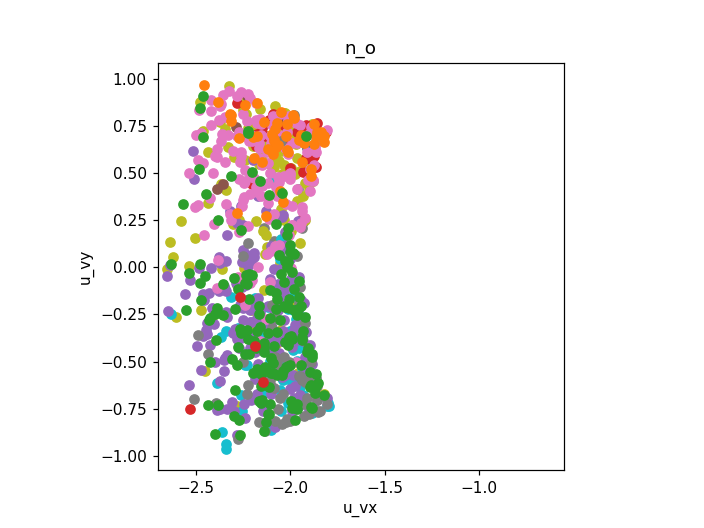

('n_o', 'c', array([], dtype=int64))
('n_o', 'c', array([], dtype=int64))
('n_o', 'c', array([], dtype=int64))
('n_o', 'c', array([], dtype=int64))
('n_o', 'c', array([], dtype=int64))
('n_o', 'c', array([], dtype=int64))
('n_o', 'c', array([], dtype=int64))
('n_o', 'c', array([67083, 67086, 67174, 67320, 67343, 67375, 67487, 67516, 67552,
       67563, 67564, 67570, 67620, 67681, 67715, 67844], dtype=int64))
('n_o', 'c', array([4685, 4692, 4694, 4695, 4726, 4729, 4730, 4734, 4759, 4763, 4764,
       4767, 4772, 4774, 4801, 4805, 4810, 4811, 4812, 4813, 4844, 4847,
       4849, 4850, 4851, 4852, 4878, 4885, 4887, 4889, 4890, 4917, 4919,
       4923, 4924, 4928, 4930, 4954, 4956, 4957, 4958, 4964, 4967, 4993,
       4997, 4998, 5000, 5004, 5005, 5006, 5008, 5035, 5039, 5041, 5043,
       5044, 5045, 5047, 5073, 5076, 5077, 5078, 5082, 5085, 5115, 5120,
       5122, 5123, 5124, 5125, 5152, 5154, 5155, 5157, 5162, 5190, 5195,
       5199, 5200, 5201, 5202, 5230, 5234, 5235, 5238, 5240, 52

In [532]:
#Pick a command

nc = {}

mag_bin = 3
angle_bin = 7

sel_mag = df_lqr['u_v_mag_bin']==mag_bin
sel_angle = df_lqr['u_v_angle_bin']==angle_bin

#Plot for all movements: 
m_list = ['n_do', 'n_o']
for m in m_list:
    sel_m = df_lqr['model']==m
    
    sel = sel_mag&sel_angle&sel_m
    sel_idxs = np.array(df_lqr[sel].index)
    print(m, sel_idxs)
    
    nc[m, 'sel_idxs'] = sel_idxs
    
    nc[m, 'n'] = df_lqr[sel][n_list]
    nc[m, 'c'] = df_lqr[sel][['u_vx', 'u_vy']]

    plt.figure()
    plt.title(m)
    for task_rot in task_rot_list:
        sel_task = df_lqr['task_rot']==task_rot
        for target in range(num_targets):
            sel_target = df_lqr['target']==target

            sel = \
            sel_m &\
            sel_mag &\
            sel_angle &\
            sel_task &\
            sel_target
            
            sel_idxs = np.array(df_lqr[sel].index)
            print(m, 'c', sel_idxs)
            
            num = np.sum(sel)
            d_c = df_lqr[sel][['u_vx', 'u_vy']]
            d_n = df_lqr[sel][n_list]
            
            nc[m, target, task_rot, 'sel_idxs'] = sel_idxs
            nc[m, target, task_rot, 'num'] = num
            nc[m, target, task_rot, 'n'] = d_n
            nc[m, target, task_rot, 'c'] = d_c

            plt.scatter(d_c['u_vx'], d_c['u_vy'], label=(task_rot,target))
    plt.axis('square')
    plt.xlabel('u_vx')
    plt.ylabel('u_vy')
    

# plt.xlim([-3, 3])
# plt.ylim([-3, 3])
# plt.legend()

In [533]:
for m in m_list:
    for dt in ['n', 'c']:
        mat = np.mat(nc[m, dt]).T
        mean = np.mean(mat,axis=1)
        nc[m, dt, 'mean'] = mean


In [534]:
nc['n_do', 'n', 'mean'].shape

(44L, 1L)

In [535]:
#Calculate distances
proj_list = ['full', 'potent', 'null']

min_num = 10
for m in m_list:
    for task_rot in task_rot_list:
        for target in range(num_targets):
            num = nc[m, target, task_rot, 'num']
            if num >= min_num:
                for dt in ['n', 'c']:
                    mat = np.mat(nc[m, target, task_rot, dt]).T
                    nc[m, target, task_rot, dt, 'mean'] = np.mean(mat, axis=1)
                    diff = nc[m, target, task_rot, dt, 'mean']-nc[m, dt, 'mean']
                    nc[m, target, task_rot, dt, 'diff', 'full'] = diff
                    if dt == 'n':
                        print(m, target, task_rot)
                        nc[m, target, task_rot, dt, 'diff', 'null'] = np.dot(decoder_null_proj, diff)
                        nc[m, target, task_rot, dt, 'diff', 'potent'] = np.dot(decoder_proj, diff)

                        for proj in proj_list:
                            diff = nc[m, target, task_rot, dt, 'diff', proj] 
                            nc[m, target, task_rot, dt, 'dist', proj] = np.linalg.norm(diff)
            

('n_do', 7, 0)
('n_do', 0, 1.1)
('n_do', 1, 1.1)
('n_do', 5, 1.1)
('n_do', 6, 1.1)
('n_do', 0, 1.2)
('n_do', 1, 1.2)
('n_do', 5, 1.2)
('n_do', 6, 1.2)
('n_do', 7, 1.2)
('n_o', 7, 0)
('n_o', 0, 1.1)
('n_o', 1, 1.1)
('n_o', 5, 1.1)
('n_o', 6, 1.1)
('n_o', 0, 1.2)
('n_o', 1, 1.2)
('n_o', 5, 1.2)
('n_o', 6, 1.2)


In [536]:
for m in m_list:
    nc[m, 'cond_list'] = []
    nc[m, 'cond_num_list'] = []
    
    for task_rot in task_rot_list:
        for target in range(num_targets):
            num = nc[m, target, task_rot, 'num']
            if num >= min_num:
                nc[m, 'cond_list'].append((target, task_rot))
                nc[m, 'cond_num_list'].append(num)

In [537]:
proj = 'null'

for m in m_list: 
    print(m)
    #print(nc[m, 'cond_list'])
    for i,cond in enumerate(nc[m, 'cond_list']):
        target = cond[0]
        task_rot = cond[1]
        dist = nc[m, target, task_rot, 'n', 'dist', proj]
        print(dist, nc[m, 'cond_num_list'][i])
    print('')

n_do
(0.36739849238763556, 22)
(0.2241318763725699, 130)
(0.20867643968579278, 75)
(0.628427783919688, 13)
(0.1317646974866604, 179)
(0.12509744903923053, 155)
(0.2761802691810405, 74)
(0.3378849234028705, 44)
(0.1340008337635535, 154)
(0.5678465048110783, 10)

n_o
(0.3630282054126048, 16)
(0.1172590574186317, 123)
(0.2125789430924281, 79)
(0.2515511175042284, 30)
(0.11782067966314551, 176)
(0.14358707545664276, 147)
(0.2129364168803182, 57)
(0.2863439337883416, 47)
(0.13823328424268136, 155)



In [638]:
m = 'n_o'


i = 0
cond = nc[m, 'cond_list'][i]
target = cond[0]
task_rot = cond[1]
num_obs = nc[m, 'cond_num_list'][i]
mean_cond = nc[m, target, task_rot, 'n', 'mean'] 
diff_cond = nc[m, target, task_rot, 'n', 'diff', 'full'] 
diff_null_cond = nc[m, target, task_rot, 'n', 'diff', 'null'] 

dist_cond = nc[m, target, task_rot, 'n', 'dist', 'full'] 
dist_null_cond = nc[m, target, task_rot, 'n', 'dist', 'null']
print(cond)
print(num_obs)

(7, 0)
16


In [639]:
diff_cond

matrix([[-0.01936736],
        [ 0.04459145],
        [-0.1312457 ],
        [-0.08339894],
        [-0.11766306],
        [ 0.01625293],
        [-0.08741623],
        [ 0.10387713],
        [ 0.1660691 ],
        [-0.04568996],
        [ 0.05739433],
        [ 0.00104312],
        [-0.00937189],
        [-0.01218036],
        [-0.0772191 ],
        [ 0.03763965],
        [ 0.03000506],
        [-0.18711463],
        [ 0.041846  ],
        [-0.00859887],
        [-0.05058497],
        [-0.00243674],
        [ 0.07681542],
        [-0.02132257],
        [ 0.10472384],
        [ 0.03867193],
        [ 0.04970757],
        [-0.03039027],
        [ 0.05116877],
        [-0.04634806],
        [-0.11413378],
        [ 0.07672896],
        [-0.09689681],
        [-0.01559229],
        [ 0.01148487],
        [-0.11074976],
        [-0.10529147],
        [-0.03698626],
        [ 0.1553969 ],
        [-0.0580288 ],
        [ 0.02381775],
        [ 0.01608744],
        [ 0.02449867],
        [-0

In [640]:
diff_null_cond

matrix([[-0.00998829],
        [ 0.03795854],
        [ 0.04015555],
        [-0.02586491],
        [-0.10865709],
        [ 0.03599561],
        [-0.07677   ],
        [ 0.0686438 ],
        [-0.02141753],
        [ 0.05311771],
        [ 0.09944237],
        [ 0.00424204],
        [-0.0140009 ],
        [-0.03513929],
        [-0.06144026],
        [ 0.05809712],
        [ 0.00655773],
        [-0.17557269],
        [ 0.02781385],
        [ 0.01439382],
        [-0.01031215],
        [ 0.02702598],
        [ 0.06432272],
        [-0.01394473],
        [ 0.07787048],
        [ 0.01623051],
        [ 0.06551946],
        [-0.00372556],
        [ 0.04621842],
        [-0.03305824],
        [-0.09285187],
        [ 0.06671505],
        [-0.07509048],
        [ 0.01151981],
        [ 0.02486516],
        [-0.05185613],
        [-0.07491623],
        [-0.02329758],
        [ 0.01497843],
        [-0.00238665],
        [ 0.01300614],
        [ 0.03923163],
        [ 0.01813002],
        [-0

In [641]:
np.allclose(decoder_null_proj*diff_null_cond, diff_null_cond)

True

In [663]:
dist_null_cond

0.3630282054126048

In [643]:
len(nc[m, 'sel_idxs'])

840

In [644]:
sel_idxs = nc[m, 'sel_idxs']
rand_idxs = np.random.choice(sel_idxs,num_obs,replace=False)
#nc[m, target, task_rot, 'sel_idxs']
#np.random.choice(sel_idxs,num_obs,replace=False)

In [666]:
model_cm[model,c,m,'pool_match_idx']

NameError: name 'model_cm' is not defined

In [ ]:
r[a,d]

In [645]:
sel_idxs

array([ 4685,  4692,  4694,  4695,  4726,  4729,  4730,  4734,  4759,
        4763,  4764,  4767,  4772,  4774,  4801,  4805,  4810,  4811,
        4812,  4813,  4844,  4847,  4849,  4850,  4851,  4852,  4878,
        4885,  4887,  4889,  4890,  4917,  4919,  4923,  4924,  4928,
        4930,  4954,  4956,  4957,  4958,  4964,  4967,  4993,  4997,
        4998,  5000,  5004,  5005,  5006,  5008,  5035,  5039,  5041,
        5043,  5044,  5045,  5047,  5073,  5076,  5077,  5078,  5082,
        5085,  5115,  5120,  5122,  5123,  5124,  5125,  5152,  5154,
        5155,  5157,  5162,  5190,  5195,  5199,  5200,  5201,  5202,
        5230,  5234,  5235,  5238,  5240,  5241,  5242,  5266,  5267,
        5268,  5276,  5277,  5278,  5279,  5280,  5305,  5306,  5314,
        5316,  5318,  5319,  5320,  5344,  5346,  5349,  5351,  5353,
        5354,  5358,  5383,  5386,  5389,  5393,  5394,  5395,  5396,
        5397,  5423,  5427,  5429,  5432,  5434,  7823,  7824,  7827,
        7828,  7829,

In [646]:
nc[m, target, task_rot, 'sel_idxs']

array([67083, 67086, 67174, 67320, 67343, 67375, 67487, 67516, 67552,
       67563, 67564, 67570, 67620, 67681, 67715, 67844], dtype=int64)

In [647]:
rand_idxs

array([ 8173,  4923,  8294, 60992,  7986,  7868,  5041, 64199, 61106,
       60982, 73491,  7980, 61445, 17492, 64354,  8494], dtype=int64)

In [648]:
df_lqr.iloc[rand_idxs][['model', 'u_v_mag_bin', 'u_v_angle_bin', 'task_rot', 'target']]

,model,u_v_mag_bin,u_v_angle_bin,task_rot,target
8173,n_o,3.0,7.0,1.2,0
4923,n_o,3.0,7.0,1.1,0
8294,n_o,3.0,7.0,1.2,0
60992,n_o,3.0,7.0,1.1,6
7986,n_o,3.0,7.0,1.2,0
7868,n_o,3.0,7.0,1.2,0
5041,n_o,3.0,7.0,1.1,0
64199,n_o,3.0,7.0,1.2,6
61106,n_o,3.0,7.0,1.1,6
60982,n_o,3.0,7.0,1.1,6


In [649]:
#Select the activity: 
df_sel = df_lqr.iloc[rand_idxs][n_list]
mat_sel = np.mat(df_sel)

In [650]:
df_sel

,n_0,n_1,n_2,n_3,n_4,n_5,n_6,n_7,n_8,n_9,...,n_34,n_35,n_36,n_37,n_38,n_39,n_40,n_41,n_42,n_43
8173,0.621132,0.128795,0.446367,0.257802,1.142140,1.454620,1.538731,-0.093567,0.458967,-0.917501,...,1.159915,0.572894,1.301686,1.137999,1.095041,1.667832,-0.332752,0.913752,0.168045,1.401867
4923,0.569254,0.354157,0.706726,0.733903,1.008406,1.853494,1.186833,0.465921,0.859810,-0.889016,...,0.669074,0.463525,1.571705,1.447554,0.810158,1.248984,0.108032,1.631853,0.020963,1.208319
8294,0.962908,0.459198,0.888454,0.558375,0.873343,1.635680,1.605709,0.141995,0.627308,-0.860716,...,0.623582,1.148354,1.292934,0.740825,0.357127,1.329228,-0.092219,1.313788,0.222051,0.801676
60992,0.623709,0.041955,0.965768,0.517754,0.597088,1.949755,1.234678,-0.113652,-0.025604,-0.402725,...,1.009369,0.914335,1.387867,0.801635,1.172577,1.495835,0.162151,1.085988,0.137968,0.714482
7986,0.519846,0.260711,0.605307,0.545073,1.182959,1.676551,1.114452,0.426077,0.596540,-0.609439,...,0.782571,0.918306,1.328566,0.335718,1.168543,1.296569,0.160027,1.806352,-0.558128,1.186564
7868,0.387125,0.375460,1.034312,0.672507,1.136098,1.670955,1.160721,0.499123,0.624883,-0.463529,...,0.770722,0.765067,1.320821,1.367489,1.061142,1.768098,-0.163734,1.334574,0.193105,1.086742
5041,0.963281,0.433261,0.504292,0.591177,0.745840,1.715003,1.022763,0.093753,0.475589,-0.384755,...,0.936430,1.073140,1.267204,1.000356,0.736301,1.525546,-0.087946,1.071368,-0.030560,0.846838
64199,0.620462,0.054148,1.145785,0.180520,0.507268,2.241498,0.884634,0.046050,0.156244,-0.182586,...,1.048780,0.505918,0.876918,1.053610,0.688852,1.579598,-0.305218,1.204401,0.335650,1.092673
61106,0.532588,0.201928,0.965905,0.710225,1.135121,1.496497,0.548714,0.471476,0.119708,-0.784658,...,0.890156,0.607400,1.317110,0.663361,0.812781,1.819318,-0.100413,1.313667,-0.013500,1.205362
60982,0.608359,0.257455,0.944800,0.853522,0.269642,1.775650,0.559605,-0.281921,0.215097,-0.483639,...,0.977999,1.086887,1.061282,0.980997,0.614403,0.766777,-0.229275,1.090497,0.569877,0.787671


In [651]:
mat_sel.shape

(16L, 44L)

In [652]:
mean_sel = np.mean(mat_sel,axis=0).T
mean_sel

matrix([[ 0.5931073 ],
        [ 0.26654843],
        [ 0.84639446],
        [ 0.60966988],
        [ 0.84464651],
        [ 1.73467768],
        [ 1.09182509],
        [ 0.14531445],
        [ 0.39943486],
        [-0.514207  ],
        [ 0.66092325],
        [ 2.05501867],
        [ 0.02591522],
        [ 0.28612477],
        [ 0.77667102],
        [ 1.62463615],
        [ 0.08526323],
        [ 0.39374056],
        [ 0.89454974],
        [ 0.64694442],
        [ 0.28075449],
        [ 1.2572508 ],
        [ 1.0177292 ],
        [ 1.35403338],
        [ 0.76495661],
        [ 0.40329477],
        [ 0.92858327],
        [ 1.07785116],
        [ 0.62956051],
        [ 0.55516386],
        [ 0.92185168],
        [ 1.65537524],
        [ 1.26285517],
        [ 0.80559882],
        [ 0.85451791],
        [ 0.89133114],
        [ 1.29366916],
        [ 0.93526958],
        [ 0.79930228],
        [ 1.5212178 ],
        [-0.04848167],
        [ 1.2249921 ],
        [ 0.25486408],
        [ 0

In [653]:
nc[m, 'n', 'mean']

matrix([[ 0.6127399 ],
        [ 0.20181298],
        [ 0.8359695 ],
        [ 0.58718206],
        [ 0.90098428],
        [ 1.78403703],
        [ 1.1166875 ],
        [ 0.09961576],
        [ 0.32677949],
        [-0.41368034],
        [ 0.75513924],
        [ 2.01639055],
        [ 0.04891771],
        [ 0.17236926],
        [ 0.8055153 ],
        [ 1.74115183],
        [ 0.10891721],
        [ 0.32221345],
        [ 0.93597857],
        [ 0.63774683],
        [ 0.31748412],
        [ 1.33236436],
        [ 1.07005852],
        [ 1.33794788],
        [ 0.7209348 ],
        [ 0.35701183],
        [ 0.96223338],
        [ 1.13885221],
        [ 0.61765496],
        [ 0.54420772],
        [ 1.0297564 ],
        [ 1.69502557],
        [ 1.22099229],
        [ 0.76231206],
        [ 0.88986727],
        [ 0.96969911],
        [ 1.31151759],
        [ 0.83033094],
        [ 0.95080459],
        [ 1.50275015],
        [-0.01965814],
        [ 1.20174602],
        [ 0.287951  ],
        [ 0

In [654]:
mean_cond

matrix([[ 0.59337254],
        [ 0.24640443],
        [ 0.7047238 ],
        [ 0.50378312],
        [ 0.78332122],
        [ 1.80028997],
        [ 1.02927127],
        [ 0.20349288],
        [ 0.49284859],
        [-0.45937031],
        [ 0.81253358],
        [ 2.01743368],
        [ 0.03954583],
        [ 0.1601889 ],
        [ 0.7282962 ],
        [ 1.77879148],
        [ 0.13892227],
        [ 0.13509882],
        [ 0.97782457],
        [ 0.62914796],
        [ 0.26689915],
        [ 1.32992762],
        [ 1.14687394],
        [ 1.31662531],
        [ 0.82565864],
        [ 0.39568376],
        [ 1.01194095],
        [ 1.10846194],
        [ 0.66882373],
        [ 0.49785965],
        [ 0.91562262],
        [ 1.77175453],
        [ 1.12409548],
        [ 0.74671976],
        [ 0.90135214],
        [ 0.85894935],
        [ 1.20622612],
        [ 0.79334468],
        [ 1.10620149],
        [ 1.44472135],
        [ 0.00415961],
        [ 1.21783346],
        [ 0.31244967],
        [ 0

In [655]:
diff_sel = mean_sel-nc[m, 'n', 'mean']
diff_sel

matrix([[-0.0196326 ],
        [ 0.06473546],
        [ 0.01042496],
        [ 0.02248782],
        [-0.05633777],
        [-0.04935936],
        [-0.02486242],
        [ 0.0456987 ],
        [ 0.07265537],
        [-0.10052665],
        [-0.09421599],
        [ 0.03862812],
        [-0.0230025 ],
        [ 0.11375551],
        [-0.02884428],
        [-0.11651568],
        [-0.02365398],
        [ 0.0715271 ],
        [-0.04142883],
        [ 0.00919759],
        [-0.03672963],
        [-0.07511356],
        [-0.05232933],
        [ 0.01608551],
        [ 0.04402181],
        [ 0.04628294],
        [-0.03365012],
        [-0.06100105],
        [ 0.01190555],
        [ 0.01095614],
        [-0.10790473],
        [-0.03965033],
        [ 0.04186288],
        [ 0.04328676],
        [-0.03534936],
        [-0.07836797],
        [-0.01784843],
        [ 0.10493864],
        [-0.15150231],
        [ 0.01846765],
        [-0.02882353],
        [ 0.02324608],
        [-0.03308692],
        [ 0

In [656]:
diff_cond

matrix([[-0.01936736],
        [ 0.04459145],
        [-0.1312457 ],
        [-0.08339894],
        [-0.11766306],
        [ 0.01625293],
        [-0.08741623],
        [ 0.10387713],
        [ 0.1660691 ],
        [-0.04568996],
        [ 0.05739433],
        [ 0.00104312],
        [-0.00937189],
        [-0.01218036],
        [-0.0772191 ],
        [ 0.03763965],
        [ 0.03000506],
        [-0.18711463],
        [ 0.041846  ],
        [-0.00859887],
        [-0.05058497],
        [-0.00243674],
        [ 0.07681542],
        [-0.02132257],
        [ 0.10472384],
        [ 0.03867193],
        [ 0.04970757],
        [-0.03039027],
        [ 0.05116877],
        [-0.04634806],
        [-0.11413378],
        [ 0.07672896],
        [-0.09689681],
        [-0.01559229],
        [ 0.01148487],
        [-0.11074976],
        [-0.10529147],
        [-0.03698626],
        [ 0.1553969 ],
        [-0.0580288 ],
        [ 0.02381775],
        [ 0.01608744],
        [ 0.02449867],
        [-0

In [657]:
diff_null_sel = decoder_null_proj*diff_sel
diff_null_sel

matrix([[-0.01530912],
        [ 0.067041  ],
        [ 0.02707373],
        [ 0.01981686],
        [-0.06024901],
        [-0.04440358],
        [-0.02505953],
        [ 0.041692  ],
        [ 0.02226071],
        [-0.06713605],
        [-0.10518804],
        [ 0.03965477],
        [-0.02422956],
        [ 0.10494174],
        [-0.0255023 ],
        [-0.11436194],
        [-0.01907685],
        [ 0.07692859],
        [-0.03622116],
        [ 0.01076816],
        [-0.02555331],
        [-0.07339561],
        [-0.05181465],
        [ 0.01624802],
        [ 0.02331394],
        [ 0.04502665],
        [-0.0321876 ],
        [-0.06270544],
        [ 0.011898  ],
        [ 0.01652293],
        [-0.10388295],
        [-0.03766007],
        [ 0.03874621],
        [ 0.04216848],
        [-0.04990653],
        [-0.07437148],
        [-0.01984868],
        [ 0.10591748],
        [-0.17430764],
        [ 0.01187261],
        [-0.00526275],
        [ 0.02246864],
        [-0.02871845],
        [ 0

In [658]:
dist_null_sel = np.linalg.norm(diff_null_sel)
dist_null_sel

0.3863660534182109

In [659]:
dist_null_cond

0.3630282054126048

<IPython.core.display.Javascript object>


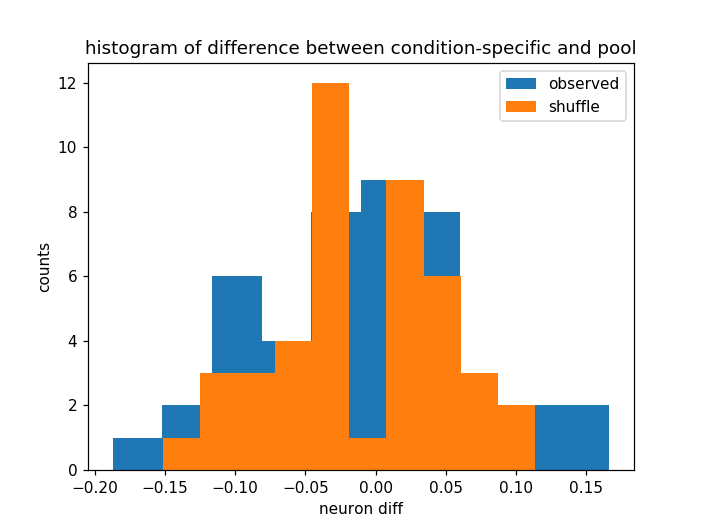

Text(0.5,1,'histogram of difference between condition-specific and pool')

In [660]:
plt.figure()
plt.hist(diff_cond, label='observed')
plt.hist(diff_sel, label='shuffle')
plt.legend()
plt.xlabel('neuron diff')
plt.ylabel('counts')
plt.title('histogram of difference between condition-specific and pool')

<IPython.core.display.Javascript object>


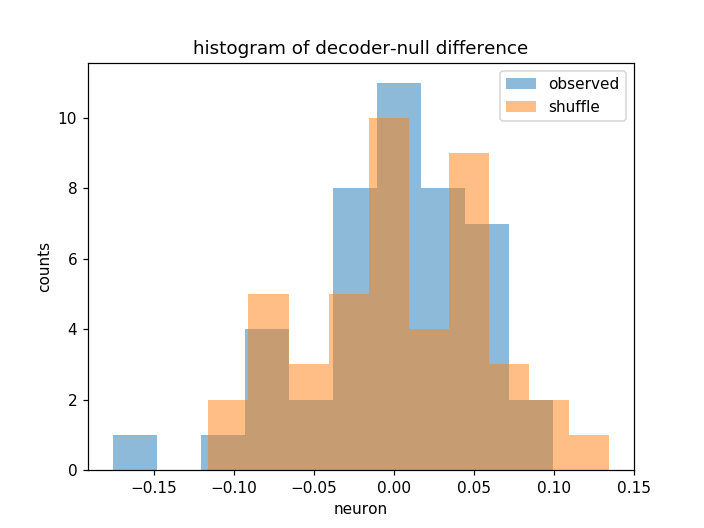

Text(0.5,1,'histogram of decoder-null difference')

In [619]:
plt.figure()
plt.hist(diff_null_cond, label='observed', alpha=0.5)
plt.hist(diff_null_sel, label='shuffle', alpha=0.5)
plt.legend()
plt.xlabel('neuron')
plt.ylabel('counts')
plt.title('histogram of decoder-null difference')

In [390]:
m

'n_o'

In [391]:
dist_sel = np.linalg.norm(diff_sel)
dist_sel

0.44853114088914386

In [392]:
dist_cond = nc[m, target, task_rot, 'n', 'dist', 'full'] 
dist_cond

0.5009391619671331

#### Check error dynamics

In [ ]:
move_lqr.keys()

In [ ]:
move_lqr[0,0,'n_do'].keys()

In [ ]:
len(move_lqr[0,0,'n_do']['A_e_list'])

In [ ]:
move_lqr[0,0,'n_do']['A_e_list'][0].shape

In [ ]:
move_lqr[0,0,'n_do']['A'].shape

In [ ]:
num_neurons

In [ ]:
target = 1
task_rot = 1.1
A_e = move_lqr[target,task_rot,'n_do']['A_e_list'][0][:num_neurons, :num_neurons]
A_e_null = decoder_null_proj*A_e*decoder_null_proj #np.dot(np.dot(decoder_null_proj, A_a), decoder_null_proj)

b_e = move_lqr[target,task_rot,'n_do']['A_e_list'][0][:num_neurons, -1]
b_e_null = decoder_null_proj*b_e

c2n_e = move_lqr[target,task_rot,'n_do']['A_e_list'][0][:num_neurons, num_neurons:-1]
c2n_e_null = decoder_null_proj*c2n_e

print(np.allclose(A_e, A_e_null))
print(np.allclose(b_e, b_e_null))
print(np.allclose(c2n_e, c2n_e_null))

In [ ]:
plt.figure()
plt.imshow(move_lqr[0,0,'n_do']['A_e_list'][0][:num_neurons,:])
plt.colorbar()

In [ ]:
# b_e = move_lqr[0,0,'n_do']['A_e_list'][0][:num_neurons,-1]
b_e = move_lqr[0,1.1,'n_do']['A_e_list'][0][num_neurons:,-1]
b_e

In [ ]:
test = move_lqr[0,0,'n_do']['A']
plt.figure(figsize=(8,8))
plt.imshow(test)
plt.colorbar()

In [ ]:
A_a = move_lqr[0,0,'n_do']['A'][:num_neurons, :num_neurons]
A_a_null = decoder_null_proj*A_a*decoder_null_proj #np.dot(np.dot(decoder_null_proj, A_a), decoder_null_proj)

b_a = move_lqr[1,0,'n_do']['A'][num_neurons:, -1]

In [ ]:
b_a

In [ ]:
np.allclose(A_a, A_a_null)

In [ ]:
plt.figure()
plt.imshow(A_a)

plt.figure()
plt.imshow(A_a_null)

In [ ]:
move_lqr[0,0,'n_do'].keys()

In [ ]:
B = move_lqr[0,0,'n_do']['B']
plt.figure()
plt.imshow(B)
print(B.shape)

#### look at single trial activity

In [466]:
df_lqr.head()

,n_0,n_1,n_2,n_3,n_4,n_5,n_6,n_7,n_8,n_9,...,u_p_angle,u_v_mag,u_v_angle,u_v_mag_bin,u_v_angle_bin,p_angle_ctr_t,v_angle_ctr_t,u_p_angle_ctr_t,u_v_angle_ctr_t,u_v_angle_ctr_bin
0,1.328601,0.496140,0.004279,-0.003336,1.202276,2.318799,1.388266,0.256369,-0.072159,0.081946,...,1.638770,8.561128e-15,1.655690,0.0,5.0,0.000000,0.000000,-4.644415,-4.627495,1.655690
1,1.324769,0.430147,0.733123,0.347118,1.301881,2.363831,1.449309,0.114034,-0.457128,0.197311,...,-2.521394,1.279243e+00,-2.521394,1.0,0.0,-0.581557,-0.581557,-2.521394,-2.521394,-2.521394
2,1.324769,0.430147,0.733123,0.347118,1.301881,2.363831,1.449309,0.114034,-0.457128,0.197311,...,-2.521394,1.279243e+00,-2.521394,1.0,0.0,-2.060744,-2.272627,-2.521394,-2.521394,-2.521394
3,1.324769,0.430147,0.733123,0.347118,1.301881,2.363831,1.449309,0.114034,-0.457128,0.197311,...,-2.521394,1.279243e+00,-2.521394,1.0,0.0,-2.227112,-2.330394,-2.521394,-2.521394,-2.521394
4,1.324769,0.430147,0.733123,0.347118,1.301881,2.363831,1.449309,0.114034,-0.457128,0.197311,...,-2.521394,1.279243e+00,-2.521394,1.0,0.0,-2.278140,-2.346698,-2.521394,-2.521394,-2.521394


In [709]:
m = 'n_do'
task = 0
target = 


sel = (df_lqr['task_rot']==task) & (df_lqr['bin']>=0) & (df_lqr['target']==target) & (df_lqr['model'] == m)
df_sel = df_lqr[sel]
#------------------------------------------------------------------------------------
#TRIALS: 
trial_start = np.where(df_sel['bin']==0)[0]
trial_stop = np.where(df_sel['bin_end']==0)[0]
trial_bound = np.vstack((trial_start,trial_stop)).T

In [710]:
trial_bound

array([[  0,  38],
       [ 39,  77],
       [ 78, 116],
       [117, 155],
       [156, 194],
       [195, 233],
       [234, 272],
       [273, 311],
       [312, 350],
       [351, 389],
       [390, 428],
       [429, 467],
       [468, 506],
       [507, 545],
       [546, 584],
       [585, 623],
       [624, 662],
       [663, 701],
       [702, 740],
       [741, 779]], dtype=int64)

<IPython.core.display.Javascript object>


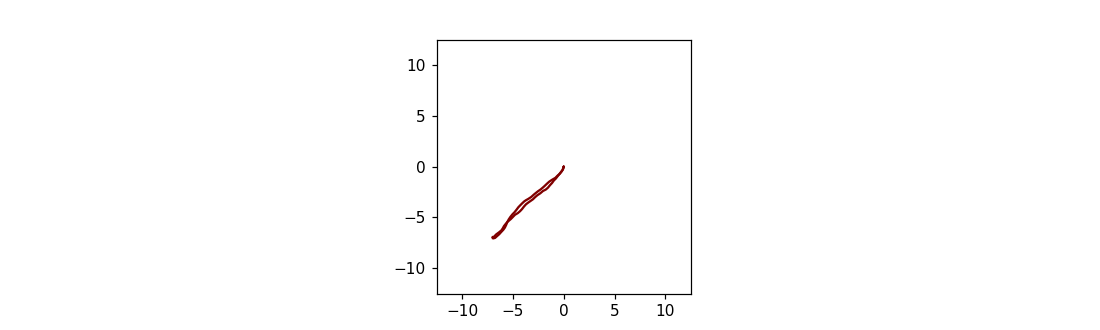

(-12.5, 12.5)

In [711]:
num_trials_plot = 2

plot = {}
plot['size'] = (10,3)
plot['xlim'] = (-12.5,12.5)
plot['ylim'] = (-12.5,12.5)
task_rot_list = [0,1.1,1.2]
task_rot_label = ['co','obs_ccw', 'obs_cw']



plt.figure(figsize=plot['size'])

#------------------------------------------------------------------------------------
#TRIALS: 
trial_start = np.where(df_sel['bin']==0)[0]
trial_stop = np.where(df_sel['bin_end']==0)[0]
trial_bound = np.vstack((trial_start,trial_stop)).T
#------------------------------------------------------------------------------------
for bnd in trial_bound[:num_trials_plot,:]: #trial_bound[0:1,:]:
#             if (task_str == 'co') or (task_str == 'obs') and (df_sel['obs_size'][bnd[0]:bnd[0]+1] == obs_big).bool(): 
    x = df_sel['kin_px'][bnd[0]:bnd[1]+1]
    y = df_sel['kin_py'][bnd[0]:bnd[1]+1]
    color = target_color[target]
    plt.plot(x,y,'-',color=color)

plt.axis('square')
plt.xlim([-12.5, 12.5])
plt.ylim([-12.5, 12.5])


In [712]:
df_sel

,n_0,n_1,n_2,n_3,n_4,n_5,n_6,n_7,n_8,n_9,...,u_p_angle,u_v_mag,u_v_angle,u_v_mag_bin,u_v_angle_bin,p_angle_ctr_t,v_angle_ctr_t,u_p_angle_ctr_t,u_v_angle_ctr_t,u_v_angle_ctr_bin
0,1.328601,0.496140,0.004279,-0.003336,1.202276,2.318799,1.388266,0.256369,-0.072159,0.081946,...,1.638770,8.561128e-15,1.655690,0.0,5.0,0.000000,0.000000,-4.644415,-4.627495,1.655690
1,1.649806,0.829527,0.752275,0.188004,1.613684,2.270020,1.021909,0.219886,-0.403178,0.372023,...,-2.374501,1.149972e+00,-2.374501,1.0,0.0,-0.581557,-0.581557,-2.374501,-2.374501,-2.374501
2,1.124026,0.880530,0.892030,0.243215,1.187094,2.570464,1.294524,0.152712,-0.812758,0.359845,...,-2.025126,1.425180e+00,-2.025126,1.0,0.0,-1.876363,-2.095460,-2.025126,-2.025126,-2.025126
3,1.439230,-0.268959,0.558292,-0.130732,1.176517,2.831184,1.347834,0.151351,-0.124002,0.587082,...,-2.582004,1.301340e+00,-2.582004,1.0,0.0,-1.928857,-1.940694,-2.582004,-2.582004,-2.582004
4,1.180915,0.203647,-0.171161,0.509937,1.467431,2.638515,1.602753,0.389464,-0.490388,0.385824,...,-2.519214,7.689903e-01,-2.519214,0.0,0.0,-2.030434,-2.206870,-2.519214,-2.519214,-2.519214
5,1.156760,0.204108,0.463114,0.002707,1.486479,2.500411,1.657255,0.111280,-0.498481,0.189976,...,3.494845,1.460060e+00,3.494845,1.0,7.0,-2.081813,-2.220767,-2.788340,-2.788340,3.494845
6,1.213880,0.584933,0.199966,0.342624,1.401178,2.816704,1.741542,0.114276,-1.239363,0.255912,...,-2.363358,1.814110e+00,-2.363358,2.0,0.0,-2.168288,-2.485106,-2.363358,-2.363358,-2.363358
7,1.127165,0.260855,0.365172,0.439285,1.372364,2.036433,1.630942,0.699580,-0.268239,0.051827,...,3.222487,1.756495e+00,3.222487,2.0,7.0,-2.213133,-2.337690,-3.060698,-3.060698,3.222487
8,1.370802,0.237313,1.030447,0.049370,1.163637,2.419986,1.028122,0.451170,-0.463357,0.523712,...,-2.542280,1.691532e+00,-2.542280,2.0,0.0,-2.292879,-2.676437,-2.542280,-2.542280,-2.542280
9,1.677598,0.348457,0.521072,0.263349,1.276764,2.277020,1.555498,0.370508,-0.537590,0.407645,...,-2.339244,1.294319e+00,-2.339244,1.0,0.0,-2.339744,-2.541102,-2.339244,-2.339244,-2.339244


In [715]:
bnd

array([39, 77], dtype=int64)

In [717]:
trial_bound

array([[  0,  38],
       [ 39,  77],
       [ 78, 116],
       [117, 155],
       [156, 194],
       [195, 233],
       [234, 272],
       [273, 311],
       [312, 350],
       [351, 389],
       [390, 428],
       [429, 467],
       [468, 506],
       [507, 545],
       [546, 584],
       [585, 623],
       [624, 662],
       [663, 701],
       [702, 740],
       [741, 779]], dtype=int64)

In [720]:
df_sel[n_list][bnd[0]:bnd[1]+1].shape

(39, 44)

In [721]:
df_trl = df_sel[n_list][bnd[0]:bnd[1]+1]
df_trl.shape

(39, 44)

In [724]:
np.array(df_trl).shape

(39L, 44L)

In [744]:
trial_bound

array([[  0,  38],
       [ 39,  77],
       [ 78, 116],
       [117, 155],
       [156, 194],
       [195, 233],
       [234, 272],
       [273, 311],
       [312, 350],
       [351, 389],
       [390, 428],
       [429, 467],
       [468, 506],
       [507, 545],
       [546, 584],
       [585, 623],
       [624, 662],
       [663, 701],
       [702, 740],
       [741, 779]], dtype=int64)

In [745]:
#Plot single trial
trl = 2
bnd = trial_bound[trl]

df_trl = df_sel[n_list][bnd[0]:bnd[1]+1]
n_mat = np.array(df_trl).T
n_mat.shape

(44L, 39L)

In [738]:
n_mat_null = decoder_null_proj*n_mat

In [739]:
n_mat_null.shape

(44L, 39L)

In [740]:
n_mat_null[0,-3]

1.4567904845064104

In [741]:
n_mat_null[0,-3]

1.4567904845064104

<IPython.core.display.Javascript object>


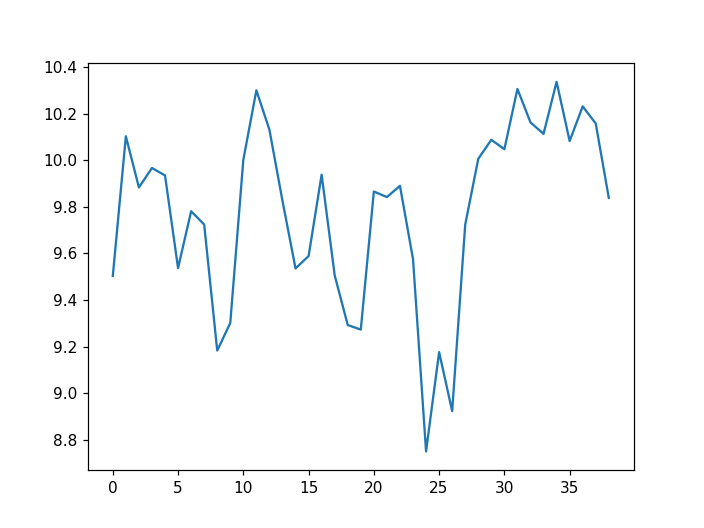

In [742]:
test = np.linalg.norm(n_mat_null,axis=0)
plt.figure()
plt.plot(test)

<IPython.core.display.Javascript object>


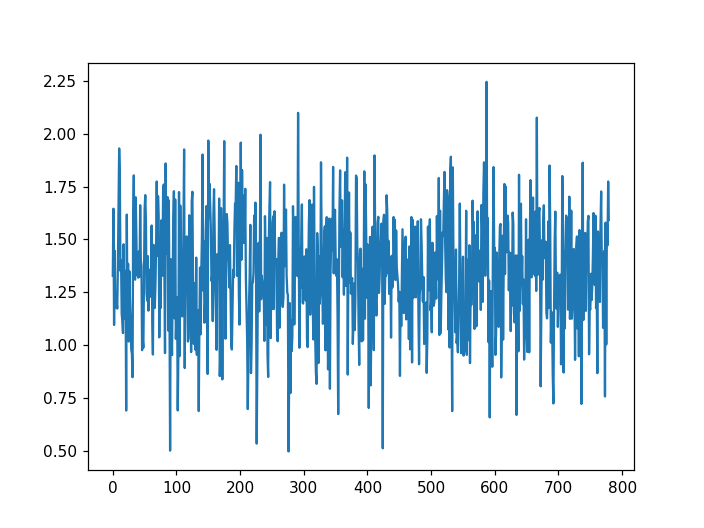

In [704]:
plt.figure()
plt.plot(np.array(n_mat_null[0,:]).squeeze())

In [492]:
n_mat_null[0,]

1.8437434181288584e-30

In [479]:
test = np.zeros(n_mat.shape)

In [480]:
i=5
cov = np.cov(decoder_null_proj*n_mat[:,:i])
print(np.trace(cov))

cov = np.cov(decoder_null_proj*n_mat[:,i:])
print(np.trace(cov))

3.601644725495728e-30
1.4329551096763496e-29


In [481]:
#m = 'n_o'

for target in [0,1]:
    for task in [0, 1.1]:
        sel = (df_lqr['task_rot']==task) & (df_lqr['bin']>=0) & (df_lqr['target']==target) & (df_lqr['model'] == m)
        df_sel = df_lqr[sel]

        n_mat = np.mat(df_sel[n_list]).T
        n_null = decoder_null_proj*n_mat
        print(n_null[:,:3])

[[ 0.67216746  0.67216746  0.67216746]
 [ 0.35283016  0.35283016  0.35283016]
 [-0.1954375  -0.1954375  -0.1954375 ]
 [-0.03740572 -0.03740572 -0.03740572]
 [ 0.68205401  0.68205401  0.68205401]
 [ 1.77116993  1.77116993  1.77116993]
 [ 0.99192332  0.99192332  0.99192332]
 [ 0.28241562  0.28241562  0.28241562]
 [ 0.31141866  0.31141866  0.31141866]
 [-0.16351578 -0.16351578 -0.16351578]
 [-0.01328462 -0.01328462 -0.01328462]
 [ 2.01153039  2.01153039  2.01153039]
 [ 0.04628492  0.04628492  0.04628492]
 [ 0.06762498  0.06762498  0.06762498]
 [ 0.78541079  0.78541079  0.78541079]
 [ 1.61674727  1.61674727  1.61674727]
 [ 0.47448939  0.47448939  0.47448939]
 [ 0.42392461  0.42392461  0.42392461]
 [ 1.24065978  1.24065978  1.24065978]
 [ 0.46101456  0.46101456  0.46101456]
 [ 0.33120238  0.33120238  0.33120238]
 [ 1.11232435  1.11232435  1.11232435]
 [ 1.19631344  1.19631344  1.19631344]
 [ 1.26347726  1.26347726  1.26347726]
 [ 0.26920068  0.26920068  0.26920068]
 [ 0.53650693  0.53650693

In [668]:
test = np.array([[1,2],[3,4], [5,6]])
test

array([[1, 2],
       [3, 4],
       [5, 6]])

In [676]:
var = n_list
idx = np.arange(10)
test_df = df.loc[idx,var]
test_df

,n_0,n_1,n_2,n_3,n_4,n_5,n_6,n_7,n_8,n_9,...,n_34,n_35,n_36,n_37,n_38,n_39,n_40,n_41,n_42,n_43
0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,1.0,3.0,3.0,7.0,1.0,2.0
1,1.0,1.0,0.0,0.0,1.0,3.0,1.0,0.0,0.0,0.0,...,1.0,3.0,1.0,1.0,2.0,1.0,2.0,4.0,0.0,1.0
2,1.0,1.0,1.0,0.0,0.0,3.0,1.0,2.0,0.0,0.0,...,0.0,1.0,3.0,2.0,3.0,3.0,4.0,11.0,0.0,5.0
3,2.0,1.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,1.0,2.0,1.0,4.0,6.0,1.0,5.0
4,0.0,0.0,0.0,0.0,3.0,1.0,3.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,2.0,1.0,3.0,3.0,0.0,1.0
5,3.0,0.0,0.0,0.0,1.0,3.0,1.0,1.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,2.0,0.0,6.0,0.0,3.0
6,0.0,2.0,0.0,0.0,5.0,3.0,4.0,0.0,0.0,0.0,...,0.0,0.0,1.0,2.0,2.0,1.0,1.0,9.0,0.0,0.0
7,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,2.0,5.0,1.0,5.0,0.0,1.0
8,0.0,1.0,0.0,0.0,2.0,3.0,2.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,2.0,4.0,0.0,0.0
9,0.0,1.0,0.0,0.0,1.0,4.0,3.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,4.0,1.0,3.0,0.0,1.0


In [679]:
arr = np.array(test_df).T
da = xr.DataArray(arr,
            coords={'v':var,
            'observation':idx+2},
            dims=['v','observation'])

In [680]:
arr

array([[ 0.,  1.,  1.,  2.,  0.,  3.,  0.,  1.,  0.,  0.],
       [ 0.,  1.,  1.,  1.,  0.,  0.,  2.,  1.,  1.,  1.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  3.,  1.,  5.,  0.,  2.,  1.],
       [ 1.,  3.,  3.,  6.,  1.,  3.,  3.,  0.,  3.,  4.],
       [ 3.,  1.,  1.,  0.,  3.,  1.,  4.,  1.,  2.,  3.],
       [ 0.,  0.,  2.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 4.,  5.,  2.,  0.,  0.,  2.,  0.,  3.,  2.,  3.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 2.,  1.,  1.,  0.,  1.,  3.,  5.,  0.,  1.,  3.],
       [ 4.,  4.,  3.,  1.,  2.,  2.,  2.,  1.,  3.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.

In [678]:
da

<xarray.DataArray (v: 44, observation: 10)>
array([[ 0.,  1.,  1., ...,  1.,  0.,  0.],
       [ 0.,  1.,  1., ...,  1.,  1.,  1.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       ...,
       [ 7.,  4., 11., ...,  5.,  4.,  3.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 2.,  1.,  5., ...,  1.,  0.,  1.]])
Coordinates:
  * observation  (observation) int32 2 3 4 5 6 7 8 9 10 11
  * v            (v) |S4 'n_0' 'n_1' 'n_2' 'n_3' ... 'n_40' 'n_41' 'n_42' 'n_43'

In [682]:
da.shape

(44L, 10L)

In [687]:
da.sel(observation=np.array([2,4]))

<xarray.DataArray (v: 44, observation: 2)>
array([[ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 1.,  3.],
       [ 3.,  1.],
       [ 0.,  2.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 4.,  2.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 2.,  1.],
       [ 4.,  3.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 1.,  3.],
       [ 0.,  1.],
       [ 0.,  0.],
       [ 1.,  1.],
       [ 1.,  2.],
       [ 3.,  1.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 1.,  1.],
       [ 1.,  3.],
       [ 0.,  3.],
       [ 0.,  0.],
       [ 0.,  2.],
       [ 4.,  2.],
       [ 5.,  5.],
       [ 0.,  1.],
       [ 0.,  0.],
       [ 1.,  1.],
       [ 1.,  3.],
       [ 0.,  2.],
       [ 1.,  3.],
       [ 3.,  3.],
       [ 3.,  4.],
       [ 7., 11.],
       [ 1.,  0.],
       [ 2.,  5.]])
Coordinates:
  * observation  (observation) int32 2 4
  * v            (v) |S4 'n_0' 'n_1' 'n_2' 'n_3' ... 'n_40' 'n_41'

In [688]:
da.sel(observation=np.array([2,4])) = -1

[autoreload of bmi_dynamics_code.behavior_co_obs failed: Traceback (most recent call last):
  File "c:\anaconda3\envs\py2\lib\site-packages\IPython\extensions\autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
  File "C:\Users\The Kraken\Documents\GitHub\bmi_dynamics_code\behavior_co_obs.py", line 1588
    cost.sel(observation=dont_discard_idx) = 0 #this ensures that these samples will never be dropped
SyntaxError: can't assign to function call
]


SyntaxError: can't assign to function call (<ipython-input-688-90104c06d99a>, line 1)

In [691]:
da.loc[dict(observation=np.array((2,4)))] = -1

In [692]:
da.loc[dict(observation=np.array((2,4)))]

<xarray.DataArray (v: 44, observation: 2)>
array([[-1., -1.],
       [-1., -1.],
       [-1., -1.],
       [-1., -1.],
       [-1., -1.],
       [-1., -1.],
       [-1., -1.],
       [-1., -1.],
       [-1., -1.],
       [-1., -1.],
       [-1., -1.],
       [-1., -1.],
       [-1., -1.],
       [-1., -1.],
       [-1., -1.],
       [-1., -1.],
       [-1., -1.],
       [-1., -1.],
       [-1., -1.],
       [-1., -1.],
       [-1., -1.],
       [-1., -1.],
       [-1., -1.],
       [-1., -1.],
       [-1., -1.],
       [-1., -1.],
       [-1., -1.],
       [-1., -1.],
       [-1., -1.],
       [-1., -1.],
       [-1., -1.],
       [-1., -1.],
       [-1., -1.],
       [-1., -1.],
       [-1., -1.],
       [-1., -1.],
       [-1., -1.],
       [-1., -1.],
       [-1., -1.],
       [-1., -1.],
       [-1., -1.],
       [-1., -1.],
       [-1., -1.],
       [-1., -1.]])
Coordinates:
  * observation  (observation) int32 2 4
  * v            (v) |S4 'n_0' 'n_1' 'n_2' 'n_3' ... 'n_40' 'n_41'

In [693]:
da

<xarray.DataArray (v: 44, observation: 10)>
array([[-1.,  1., -1., ...,  1.,  0.,  0.],
       [-1.,  1., -1., ...,  1.,  1.,  1.],
       [-1.,  0., -1., ...,  0.,  0.,  0.],
       ...,
       [-1.,  4., -1., ...,  5.,  4.,  3.],
       [-1.,  0., -1., ...,  0.,  0.,  0.],
       [-1.,  1., -1., ...,  1.,  0.,  1.]])
Coordinates:
  * observation  (observation) int32 2 3 4 5 6 7 8 9 10 11
  * v            (v) |S4 'n_0' 'n_1' 'n_2' 'n_3' ... 'n_40' 'n_41' 'n_42' 'n_43'